In [155]:
# tools for handling files
import sys
import os
# pandas/numpy for handling data
import pandas as pd
import numpy as np
# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns
# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# for reading individual telomere length data from files
from ast import literal_eval
# for grabbing individual cells
import more_itertools
# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

# machine learning 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, auc, accuracy_score, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from bayes_opt import BayesianOptimization
import xgboost
import shap
import imgkit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

# setting darkgrid style for seaborn figures
# sns.set(font='helvetica')
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Machine Learning (ML) - predicting mean telomere length post-therapy (4 C) using pre-therapy individual telos

## Loading/merging data for ML

In [279]:
exploded_telos_all_patients_df = pd.read_csv('../data/compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')

In [280]:
# cleaning & combing data; retaining features of interest
telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, all_patients_df=all_patients_df)
print(telo_data.shape)
telo_data_head_8 = telo_data.head(8)

(128800, 4)


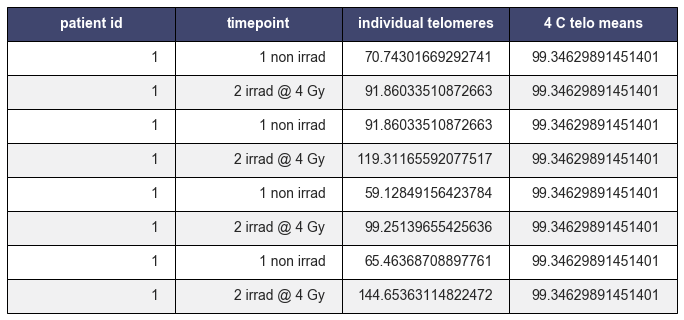

In [281]:
path=f'../graphs/paper figures/supp figs/view of precleaned individual telomere length dataframe.png'
trp.render_mpl_table(telo_data_head_8, col_width=3, path=path)

## Train/test split 

In [318]:
telo_test = telo_data.copy()
train_set, test_set = train_test_split(telo_test, test_size=0.2, shuffle=True, stratify=telo_test[['patient id', 
                                                                                                   'timepoint']])

## Initializing cleaning/model pipelines

In [319]:
clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [320]:
model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.2, gamma=0.5,
                     objective ='reg:squarederror', random_state=1)

xgb_pipe = Pipeline([('XGB', model)
                    ])

full_pipe = Pipeline([('clean_process', clean_process_pipe),
                      ('model', model)
                     ])

## Cleaning data with pipeline

In [321]:
train_clean = train_set.copy()
test_clean = test_set.copy()

train_clean = clean_process_pipe.fit_transform(train_clean)
test_clean = clean_process_pipe.fit_transform(test_clean)

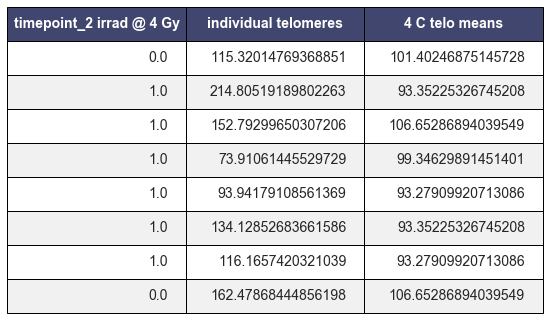

In [100]:
train_clean_head_8 = train_clean[['timepoint_2 irrad @ 4 Gy', 'individual telomeres', '4 C telo means']].copy().head(8)
path=f'../graphs/paper figures/supp figs/view of cleaned individual telomere length dataframe.png'
trp.render_mpl_table(train_clean_head_8, col_width=3.2, path=path)

## Random GridSearch for pipeline/model params

In [121]:
# #XGBoost params for random grid search
# param_grid = {'XGB__max_depth': [3, 7, 9],
#               'XGB__learning_rate': [0.05, 0.1]}

# X_train = train_clean[['individual telomeres', 'timepoint_1']].copy()
# y_train = train_clean['4 C telo means'].copy()

# folds = KFold(5, shuffle=True, random_state=0)
# df_results, best_estimator = trp.grid_search(X_train, y_train, xgb_pipe, param_grid, 
#                                           scoring='neg_mean_absolute_error', cv=folds, n_iter=2)
# print(best_estimator)

## Bayesian Optimization

In [122]:
# target = '4 C telo means'
# features = [col for col in train_clean if col != target and col != 'patient id']

# X_train = train_clean[features].copy()
# y_train = train_clean[target].copy()

In [123]:
# pbounds = {
#     'learning_rate': (0.1, 0.2),
#     'n_estimators': (100, 200),
#     'max_depth': (3, 30),
#     'subsample': (.80, 1.0),  
#     'colsample': (1.0, 1.0),  # Change for datasets with lots of features
#     'gamma': (0, 1)}

# def xgboost_hyper_param(learning_rate, n_estimators, max_depth,
#                         subsample, colsample, gamma):
 
#     max_depth = int(max_depth)
#     n_estimators = int(n_estimators)
 
#     clf = XGBRegressor(max_depth=max_depth,
#                        learning_rate=learning_rate,
#                        n_estimators=n_estimators,
#                        gamma=gamma, objective='reg:squarederror')
    
#     return np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
 
# optimizer = BayesianOptimization(
#     f=xgboost_hyper_param,
#     pbounds=pbounds,
#     random_state=1,)

# optimizer.maximize(init_points=10, n_iter=5)

In [124]:
# bayesian optimized model
# bo_model = XGBRegressor(n_estimators=260, max_depth=17, learning_rate=0.25,
#                        objective ='reg:squarederror', random_state=0, subsample=.9,
#                        gamma=1.7)

## Visualizing model objective

In [13]:
# train_viz = train_set.copy()
# train_viz.sort_values(by=['patient id'], axis=0, ascending=True, inplace=True)
# trp.plot_individ_telos_ML_objective(df=train_viz, target='4 C telo means')

## Cross validation; MAE & R2 score 

In [322]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_xgb_model, telo_row = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                                    model=model, cv=5)

MAE per CV fold: 
[3.18713504 3.15315735 3.22645684 3.17134863 3.14790199] 

MEAN of MAE all folds: 3.177199968552146
STD of MAE all folds: 0.028268717645937812

MAE of predict_y_test & y_test: 3.2158892911519397
R2 between predict_y_test & y_test: 0.8836783976886133


In [323]:
testing = test_set.copy()
testing.reset_index(drop=True, inplace=True)
testing_IDs = testing[['patient id', '4 C telo means']]
testing_features = testing[['timepoint', 'individual telomeres']].copy()
testing_features.reset_index(drop=True, inplace=True)

def apply_labels(row):
    if row == '1 non irrad':
        return 0
    elif row == '2 irrad @ 4 Gy':
        return 1
    
testing_features['timepoint_2 irrad @ 4 Gy'] = testing['timepoint'].apply(lambda row: apply_labels(row))
testing_features.drop(['timepoint'], axis=1, inplace=True)

predictions = fit_xgb_model.predict(testing_features)
predict_vals = pd.DataFrame({'predictions':predictions})

combined = pd.concat([predict_vals, testing_features, testing_IDs], axis=1)
combined.head()

predictions  individual telomeres  timepoint_2 irrad @ 4 Gy  patient id  \
0   105.126022            185.859015                         0           2   
1    92.980072             46.465832                         1          14   
2   101.083336             98.221143                         1           5   
3    82.044785            107.438231                         1          12   
4    98.712112            116.984279                         0          10   

   4 C telo means  
0      108.915327  
1       93.279099  
2       97.832190  
3       73.988380  
4       93.352253

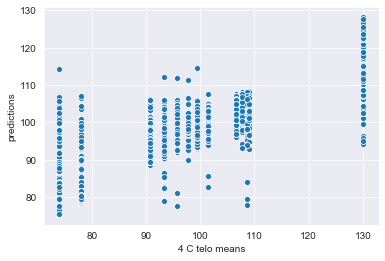

In [324]:
sns.scatterplot(x='4 C telo means', y='predictions', data=combined)

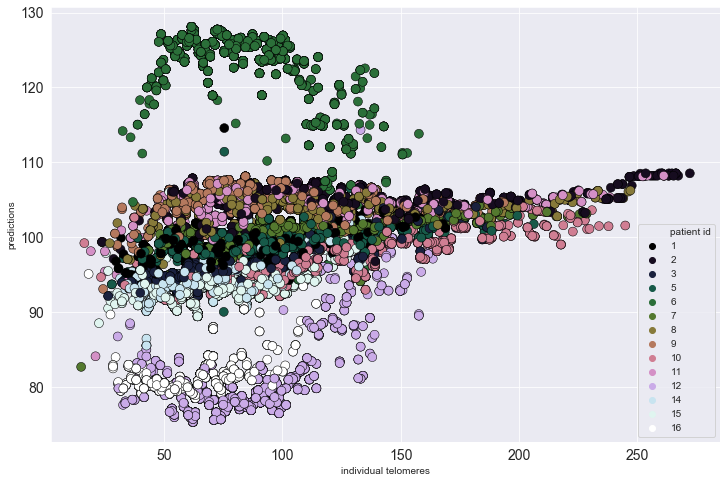

In [327]:
sns.set_color_codes()
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x='individual telomeres', y='predictions', 
                     hue='patient id', 
                     data=combined, 
                     s=80, 
                     linewidth=.5, 
                     edgecolor='black',
                     legend='full', 
                     palette='cubehelix')

# ax.set_xlabel("Actual post-therapy mean telomere lengths", fontsize=14)
# ax.set_ylabel("Predicted post-therapy mean telomere lengths", fontsize=14)
ax.tick_params(labelsize=14)

In [15]:
# evaluating model based on N samples in training data
telo_model_df = []

for n in [100, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 103040]:
    fit_xgb_model, telo_row = trp.cv_score_fit_mae_test(train_set=train_clean.sample(n), test_set=test_clean,
                                                        target='4 C telo means',
                                                        model=model, cv=5, verbose=False)
    telo_row[0].append(n)
    telo_model_df += (telo_row)

In [16]:
model_metrics_n_train = pd.DataFrame(telo_model_df, 
                                     columns=['Model', 'Features', 'Target', 'Average MAE of CV folds', 
                                              'Std dev of MAE of CV folds', 'MAE predicted vs. test values', 
                                              'R2 predicted vs. test values', 'N samples training data'])
model_metrics_n_train['Features'] = model_metrics_n_train['Features'].apply(lambda row: ', '.join(row))
model_metrics_n_train['Features'] = 'individual telos, encoded samples'

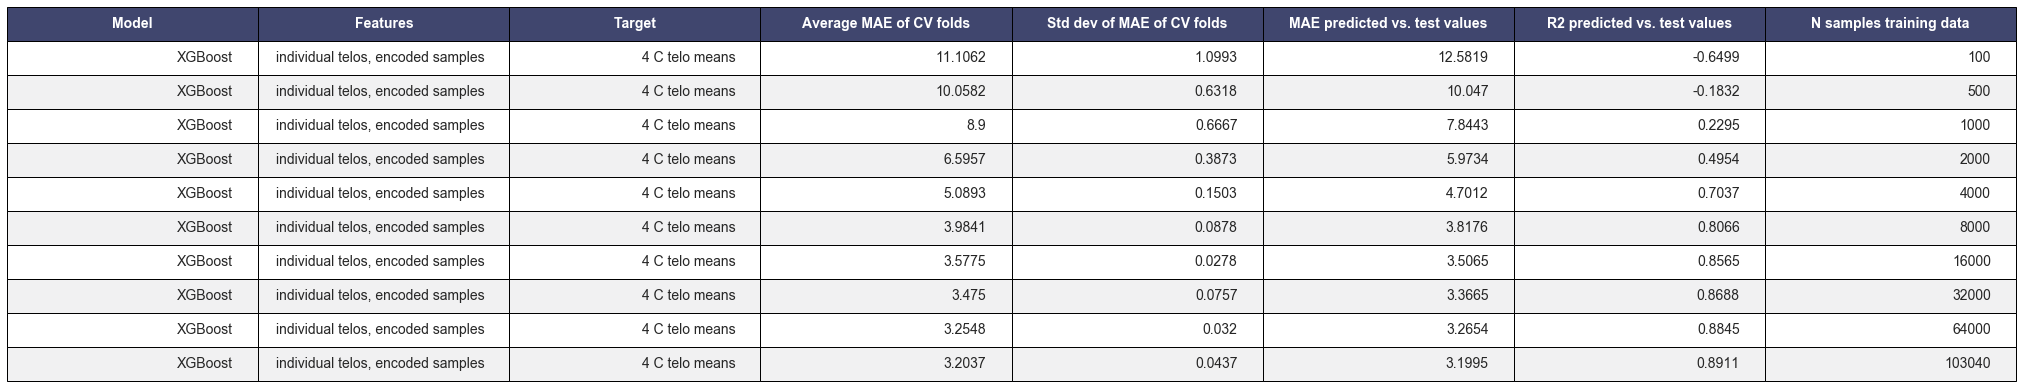

In [116]:
path=f'../graphs/paper figures/supp figs/ML model metrics target_4C mean telos | per N training samples 100 to 100000.png'
trp.render_mpl_table(model_metrics_n_train, col_width=4.5, path=path)

path=f'../graphs/paper figures/supp figs/ML model metrics target_4C mean telos | per N training samples 100 to 100000.png'
trp.df_to_png(df=model_metrics_n_train, path=path)
trp.render_mpl_table

In [201]:
y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                                                   model=fit_xgb_model, target='4 C telo means',
                                                                   clean_process_pipe=clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C telo means: 3.01532437767921
R2 predicted vs. actual 4 C telo means: 0.9264877840554109


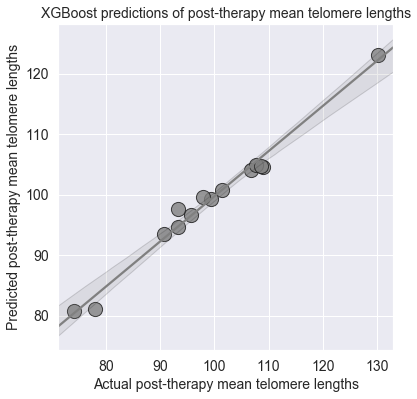

In [350]:
sns.set_color_codes()

plt.figure(figsize=(6,6))

ax = sns.regplot(x=y_true_list, y=y_predict_list, scatter_kws={'s':200, 'edgecolor':'k'}, color='grey',)


ax.set_xlabel("Actual post-therapy mean telomere lengths", fontsize=14)
ax.set_ylabel("Predicted post-therapy mean telomere lengths", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title('XGBoost predictions of post-therapy mean telomere lengths', fontsize=14, )
plt.savefig(f'../graphs/paper figures/main figs/ML model actual 4 C mean telos vs predicted.png', 
            dpi=400, bbox_inches = "tight")

## Dataframe for model metrics

In [23]:
stats_df = trp.make_stats_df(stats_list=telo_row)
stats_df

Model                                          Features          Target  \
0  XGBoost  [individual telomeres, timepoint_2 irrad @ 4 Gy]  4 C telo means   

   Average MAE of CV folds  Std dev of MAE of CV folds  \
0                   3.2037                      0.0437   

   MAE predicted vs. test values  R2 predicted vs. test values  \
0                         3.1995                        0.8911   

   N samples training data  
0                   103040

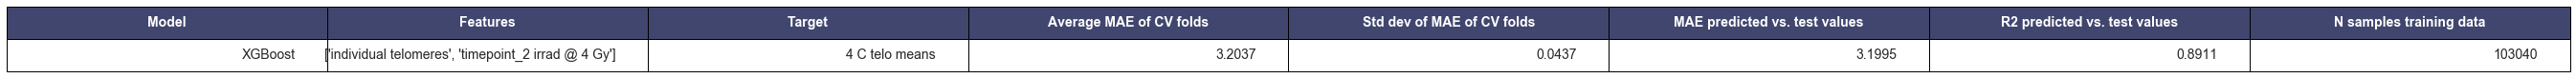

In [24]:
path=f'../graphs/paper figures/supp figs/ML model metrics target_4C mean telos | features_individ telos.png'
trp.render_mpl_table(stats_df, col_width=6, path=path)

## Trialing model interpretability functions

In [76]:
shap.initjs()

X = test_clean.drop('4 C telo means', axis=1).sample(5000, random_state=2)

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(fit_xgb_model)
shap_values = explainer.shap_values(X)

# change to jupyter theme light mode for viz
shap.force_plot(explainer.expected_value, shap_values, X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
shap.force_plot is slow for many thousands of rows, try subsampling your data.


## Testing if linear regression can predict 4C mean telos using individual telos

In [ ]:
lr_model = LinearRegression(normalize=True)
lr_pipe = Pipeline([('lr_model', lr_model)
                   ])

In [ ]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_lr_model, row = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                              model=lr_model, cv=5)

In [ ]:
lr_y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                     model=fit_lr_model, target='4 C telo means',
                                     clean_process_pipe=clean_process_pipe, verbose=False)

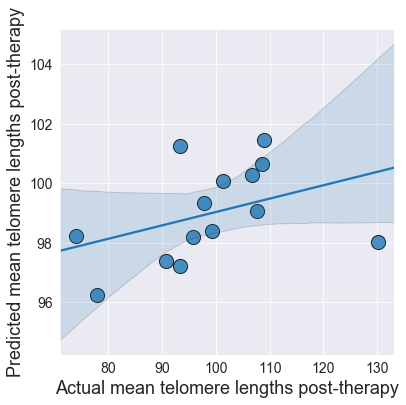

In [26]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=y_true_list, y=lr_y_predict_list, scatter_kws={'s':200, 'edgecolor':'k'},)
ax.set_xlabel('Actual mean telomere lengths post-therapy', fontsize=18)
ax.set_ylabel('Predicted mean telomere lengths post-therapy', fontsize=18)
ax.tick_params(labelsize=14)

# Machine Learning - exploring predictions of #s of short telomeres post-therapy

## Loading/merging data for ML

In [25]:
exploded_telos_all_patients_df = pd.read_csv('../data/compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')

In [26]:
# cleaning & combing data; retaining features of interest
quartile_telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                                      all_patients_df=all_patients_df,
                                      pred_obj='4 C # short telos from individual telos')
quartile_telo_data.head()

patient id       timepoint  individual telomeres  4 C # short telos
0           1     1 non irrad             70.743017                372
1           1  2 irrad @ 4 Gy             91.860335                372
2           1     1 non irrad             91.860335                372
3           1  2 irrad @ 4 Gy            119.311656                372
4           1     1 non irrad             59.128492                372

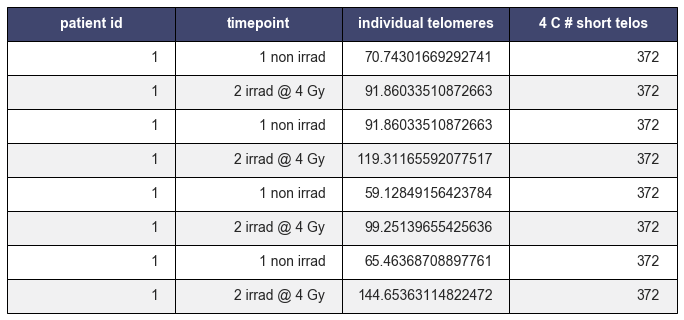

In [95]:
# saving view of preprocessed data
quartile_telo_head_8 = quartile_telo_data.head(8)
path=f'../graphs/paper figures/supp figs/view of precleaned individual telomere length SHORT TELOS dataframe.png'
trp.render_mpl_table(quartile_telo_head_8, col_width=3, path=path)

## Train/test split 

In [28]:
quartile_telo_test = quartile_telo_data.copy()

y = quartile_telo_test[['4 C # short telos']]
X = quartile_telo_test.drop(['4 C # short telos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

q_train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
q_test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [29]:
q_clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [30]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
q_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2,
                       objective='reg:squarederror', random_state=1, gamma=0.5)

q_xgb_pipe = Pipeline([('XGB', model)
                      ])

q_full_pipe = Pipeline([('clean_process', q_clean_process_pipe),
                        ('model', q_model)
                       ])

## Cleaning/modeling data with pipeline

In [31]:
q_train_clean = q_train_set.copy()
q_test_clean = q_test_set.copy()

q_train_clean = q_clean_process_pipe.fit_transform(q_train_clean)
q_test_clean = q_clean_process_pipe.fit_transform(q_test_clean)

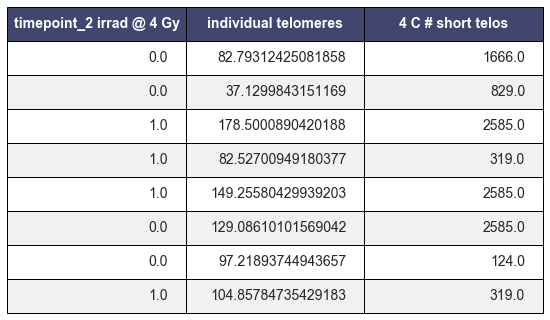

In [96]:
# saving view of post-processed data
q_train_clean_head_8 = q_train_clean[['timepoint_2 irrad @ 4 Gy', 
                                       'individual telomeres', 
                                       '4 C # short telos']].copy().head(8)

path=f'../graphs/paper figures/supp figs/view of cleaned individual telomere length SHORT TELOS dataframe.png'
trp.render_mpl_table(q_train_clean_head_8, col_width=3.2, path=path)

## Visualizing model objective

In [228]:
# q_train_set.sort_values(by='patient id', ascending=True, inplace=True)
# q_train_set.reset_index(drop=True, inplace=True)
# temp = q_train_set.copy()
# temp['4 C # short telos'] = temp['4 C # short telos'] / 10

# trp.plot_individ_telos_ML_objective(df=temp, target='4 C # short telos')

## Cross validation; MAE & R2 score when predicting # of short telomeres post-therapy (4 C)

In [33]:
q_fit_xgb_model, short_telos_row = trp.cv_score_fit_mae_test(train_set=q_train_clean, 
                                                                 test_set=q_test_clean, model=q_model, 
                                                                 cv=5, target='4 C # short telos',
                                                                 verbose=False)

In [34]:
# evaluating model based on N samples in training data
short_telos_model_df = []

for n in [100, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 103040]:
    q_fit_xgb_model, short_telos_row = trp.cv_score_fit_mae_test(train_set=q_train_clean.sample(n), 
                                                                 test_set=q_test_clean, model=q_model, 
                                                                 cv=5, target='4 C # short telos',
                                                                 verbose=False)
    short_telos_row[0].append(n)
    short_telos_model_df += (short_telos_row)

In [120]:
q_model_metrics_n_train = pd.DataFrame(short_telos_model_df, 
                                     columns=['Model', 'Features', 'Target', 'Average MAE of CV folds', 
                                              'Std dev of MAE of CV folds', 'MAE predicted vs. test values', 
                                              'R2 predicted vs. test values', 'N samples training data'])

q_model_metrics_n_train['Features'] = q_model_metrics_n_train['Features'].apply(lambda row: ', '.join(row))
q_model_metrics_n_train['Features'] = 'individual telos, encoded samples'

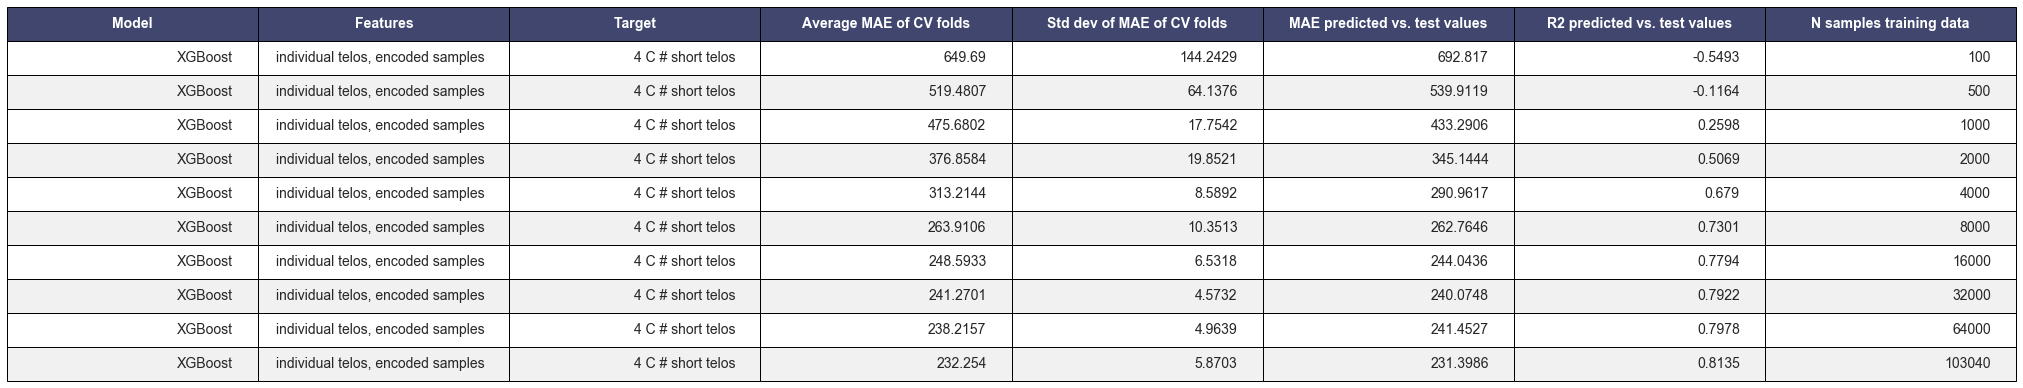

In [121]:
# display(q_model_metrics_n_train)
path=f'../graphs/paper figures/supp figs/ML model metrics target_4C number short telos | per N training samples 100 to 100000.png'
trp.render_mpl_table(q_model_metrics_n_train, col_width=4.5, path=path)

In [264]:
q_y_xgb_predict, q_y_true = trp.predict_target_4C_compare_actual(telo_data=quartile_telo_data, test_set=q_test_set, 
                                                                 model=q_fit_xgb_model, target='4 C # short telos',
                                                                 clean_process_pipe=q_clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C # short telos: 210.76881408691406
R2 predicted vs. actual 4 C # short telos: 0.8725634155107621


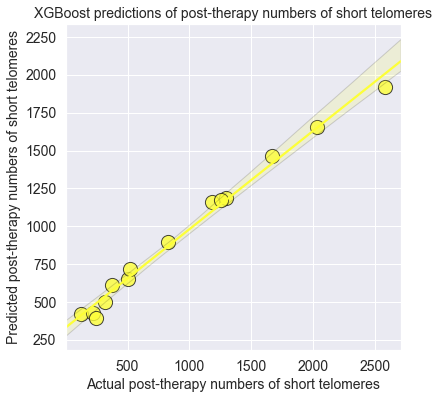

In [265]:
sns.set_color_codes()

plt.figure(figsize=(6,6))
ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, color='#fdff38')
ax.set_xlabel("Actual post-therapy numbers of short telomeres", fontsize=14)
ax.set_ylabel("Predicted post-therapy numbers of short telomeres", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title('XGBoost predictions of post-therapy numbers of short telomeres', fontsize=14, )
plt.savefig(f'../graphs/paper figures/main figs/ML model actual 4 C # short telomeres vs predicted.png', 
            dpi=400, bbox_inches = "tight")

In [248]:
# q_test_set

In [264]:
testing = q_test_set.copy()
testing.reset_index(drop=True, inplace=True)
testing_IDs = testing[['patient id', '4 C # short telos']]
testing_features = testing[['timepoint', 'individual telomeres']].copy()

def apply_labels(row):
    if row == '1 non irrad':
        return 0
    elif row == '2 irrad @ 4 Gy':
        return 1
    
testing_features['timepoint_2 irrad @ 4 Gy'] = testing['timepoint'].apply(lambda row: apply_labels(row))
testing_features.drop(['timepoint'], axis=1, inplace=True)

predictions = q_fit_xgb_model.predict(testing_features)
predict_vals = pd.DataFrame({'predictions':predictions})

combined = pd.concat([predict_vals, testing_features, testing_IDs], axis=1)
combined.head()

predictions  individual telomeres  timepoint_2 irrad @ 4 Gy  patient id  \
0   660.414917             72.424967                         1           5   
1   470.834900             75.730668                         1          15   
2  2139.181396            123.035190                         1          10   
3   482.791412             91.265163                         0          15   
4  2169.424072            113.958824                         1          10   

   4 C # short telos  
0                521  
1                319  
2               2585  
3                319  
4               2585

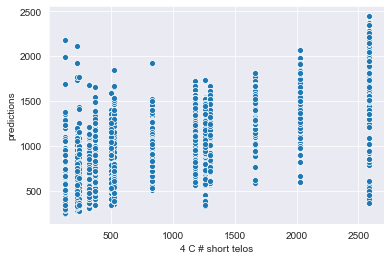

In [265]:
sns.scatterplot(x='4 C # short telos', y='predictions', data=combined)

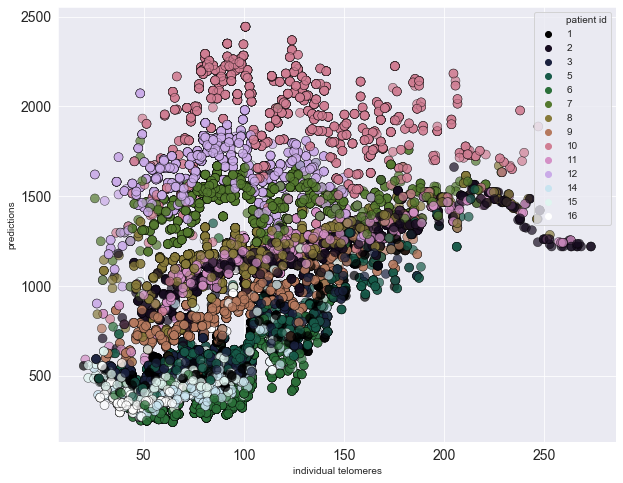

In [266]:
sns.set_color_codes()
plt.figure(figsize=(10,8))
ax = sns.scatterplot(x='individual telomeres', y='predictions', hue='patient id', data=combined, 
                     s=80, 
                     alpha=.7,
                     linewidth=.5, 
                     edgecolor='black',
                     legend='full', 
                     palette='cubehelix')

# ax.set_xlabel("Actual post-therapy mean telomere lengths", fontsize=14)
# ax.set_ylabel("Predicted post-therapy mean telomere lengths", fontsize=14)
ax.tick_params(labelsize=14)

## Dataframe for model metrics

In [283]:
telo_row[0].append(103040)
short_telos_row[0].append(103040)

telos_short_telos_rows = telo_row + short_telos_row
stats_df = trp.make_stats_df(stats_list=telos_short_telos_rows)
stats_df

Model                                          Features  \
0  XGBoost  [individual telomeres, timepoint_2 irrad @ 4 Gy]   
1  XGBoost  [individual telomeres, timepoint_2 irrad @ 4 Gy]   

              Target  Average MAE of CV folds  Std dev of MAE of CV folds  \
0     4 C telo means                   3.2051                      0.0565   
1  4 C # short telos                 235.9586                      1.9788   

   MAE predicted vs. test values  R2 predicted vs. test values  \
0                         3.2038                        0.8874   
1                       231.9450                        0.8164   

   N samples training data  
0                   103040  
1                   103040

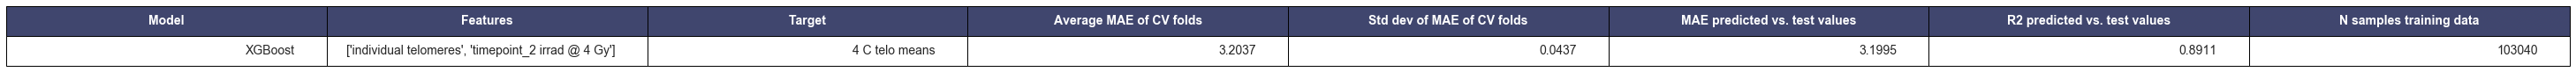

In [37]:
path=f'../graphs/paper figures/supp figs/ML models predicting #1 4 C telo means and #2 # short telos.png'
trp.render_mpl_table(stats_df, col_width=6.5, path=path)

# Machine Learning - exploring predictions of #s of long telomeres post-therapy

## Loading/merging data for ML

In [38]:
exploded_telos_all_patients_df = pd.read_csv('../data/compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')

In [39]:
long_telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                                      all_patients_df=all_patients_df,
                                      pred_obj='4 C # long telos from individual telos')
long_telo_data.head()

patient id       timepoint  individual telomeres  4 C # long telos
0           1     1 non irrad             70.743017              1987
1           1  2 irrad @ 4 Gy             91.860335              1987
2           1     1 non irrad             91.860335              1987
3           1  2 irrad @ 4 Gy            119.311656              1987
4           1     1 non irrad             59.128492              1987

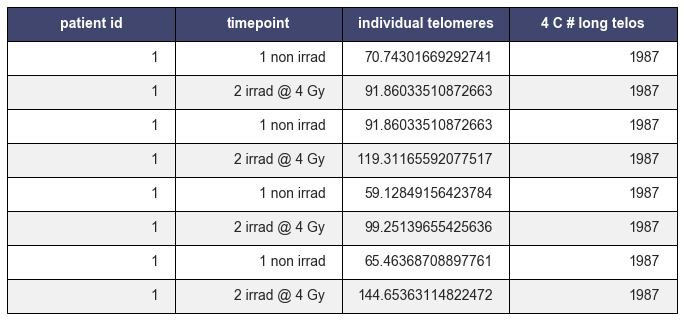

In [97]:
# saving view of preprocessed data
long_telo_head_8 = long_telo_data.head(8)
path=f'../graphs/paper figures/supp figs/view of precleaned individual telomere length LONG TELOS dataframe.png'
trp.render_mpl_table(long_telo_head_8, col_width=3, path=path)

## Train/test split 

In [41]:
long_telo_test = long_telo_data.copy()

y = long_telo_test[['4 C # long telos']]
X = long_telo_test.drop(['4 C # long telos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

long_train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
long_test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [42]:
long_clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [43]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
long_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2,
                       objective='reg:squarederror', random_state=1, gamma=0.5)

long_xgb_pipe = Pipeline([('XGB', model)
                      ])

long_full_pipe = Pipeline([('clean_process', long_clean_process_pipe),
                        ('model', long_model)
                       ])

## Cleaning/modeling data with pipeline

In [44]:
long_train_clean = long_train_set.copy()
long_test_clean = long_test_set.copy()

long_train_clean = long_clean_process_pipe.fit_transform(long_train_clean)
long_test_clean = long_clean_process_pipe.fit_transform(long_test_clean)

In [45]:
long_train_clean.head()

individual telomeres  4 C # long telos  timepoint_2 irrad @ 4 Gy
0             75.394278            3806.0                         0
1             71.433559            2026.0                         0
2             43.435886            3353.0                         1
3            129.086101             365.0                         0
4            105.876448            1808.0                         0

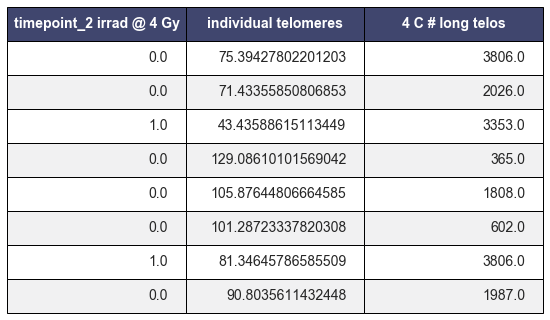

In [98]:
# saving view of post-processed data
long_train_clean_head_8 = long_train_clean[['timepoint_2 irrad @ 4 Gy', 
                                       'individual telomeres', 
                                       '4 C # long telos']].copy().head(8)

path=f'../graphs/paper figures/supp figs/view of cleaned individual telomere length LONG TELOS dataframe.png'
trp.render_mpl_table(long_train_clean_head_8, col_width=3.2, path=path)

## Visualizing model objective

In [298]:
# long_train_set.sort_values(by='patient id', ascending=True, inplace=True)
# long_train_set.reset_index(drop=True, inplace=True)
# temp = long_train_set.copy()
# temp['4 C # long telos'] = temp['4 C # long telos'] / 20

# trp.plot_individ_telos_ML_objective(df=temp, target='4 C # long telos')

## Cross validation; MAE & R2 score when predicting # of short telomeres post-therapy (4 C)

In [51]:
long_fit_xgb_model, long_telos_row = trp.cv_score_fit_mae_test(train_set=long_train_clean, 
                                                                 test_set=long_test_clean, model=long_model, 
                                                                 cv=5, target='4 C # long telos',
                                                                 verbose=True)

MAE per CV fold: 
[329.12207939 326.5741335  333.23213782 326.08542475 316.80582876] 

MEAN of MAE all folds: 326.36392084678505
STD of MAE all folds: 5.4084880816707654

MAE of predict_y_test & y_test: 328.59782107098505
R2 between predict_y_test & y_test: 0.8272898116170375


In [52]:
# evaluating model based on N samples in training data
long_telos_model_df = []

for n in [100, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 103040]:
    long_fit_xgb_model, long_telos_row = trp.cv_score_fit_mae_test(train_set=long_train_clean.sample(n), 
                                                                 test_set=long_test_clean, model=long_model, 
                                                                 cv=5, target='4 C # long telos',
                                                                 verbose=False)
    long_telos_row[0].append(n)
    long_telos_model_df += (long_telos_row)

In [122]:
long_model_metrics_n_train = pd.DataFrame(long_telos_model_df, 
                                     columns=['Model', 'Features', 'Target', 'Average MAE of CV folds', 
                                              'Std dev of MAE of CV folds', 'MAE predicted vs. test values', 
                                              'R2 predicted vs. test values', 'N samples training data'])

long_model_metrics_n_train['Features'] = long_model_metrics_n_train['Features'].apply(lambda row: ', '.join(row))
long_model_metrics_n_train['Features'] = 'individual telos, encoded samples'

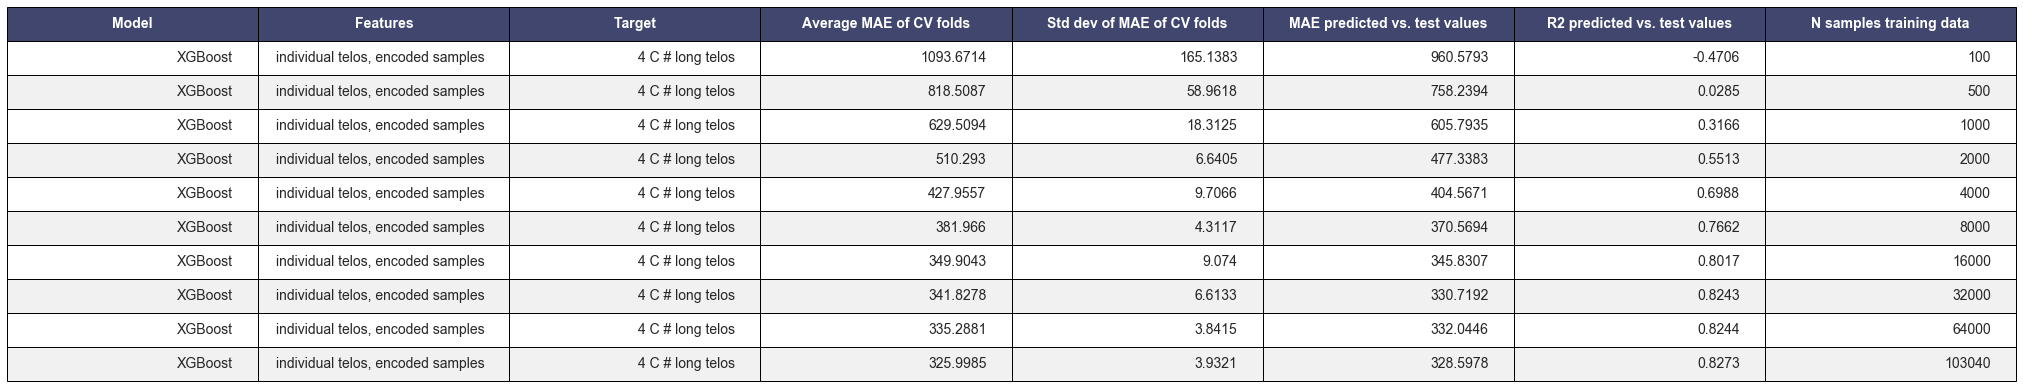

In [123]:
# display(long_model_metrics_n_train)
path=f'../graphs/paper figures/supp figs/ML model metrics target_4C number long telos | per N training samples 100 to 100000.png'
trp.render_mpl_table(long_model_metrics_n_train, col_width=4.5, path=path)

In [304]:
long_y_xgb_predict, long_y_true = trp.predict_target_4C_compare_actual(telo_data=long_telo_data, test_set=long_test_set, 
                                                                 model=long_fit_xgb_model, target='4 C # long telos',
                                                                 clean_process_pipe=long_clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C # long telos: 287.75706699916293
R2 predicted vs. actual 4 C # long telos: 0.8888774755119393


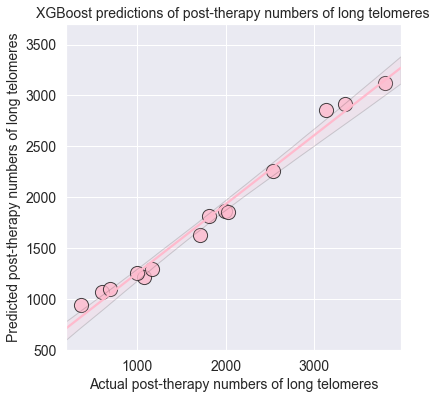

In [306]:
sns.set_color_codes()

plt.figure(figsize=(6,6))
ax = sns.regplot(x=long_y_true, y=long_y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, color='#ffbacd')
ax.set_xlabel("Actual post-therapy numbers of long telomeres", fontsize=14)
ax.set_ylabel("Predicted post-therapy numbers of long telomeres", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title('XGBoost predictions of post-therapy numbers of long telomeres', fontsize=14, )
plt.ylim(500, 3700)
plt.savefig(f'../graphs/paper figures/main figs/ML model actual 4 C # long telomeres vs predicted.png', 
            dpi=400, bbox_inches = "tight")

In [267]:
testing = long_test_set.copy()
testing.reset_index(drop=True, inplace=True)
testing_IDs = testing[['patient id', '4 C # long telos']]
testing_features = testing[['timepoint', 'individual telomeres']].copy()

def apply_labels(row):
    if row == '1 non irrad':
        return 0
    elif row == '2 irrad @ 4 Gy':
        return 1
    
testing_features['timepoint_2 irrad @ 4 Gy'] = testing['timepoint'].apply(lambda row: apply_labels(row))
testing_features.drop(['timepoint'], axis=1, inplace=True)

predictions = q_fit_xgb_model.predict(testing_features)
predict_vals = pd.DataFrame({'predictions':predictions})

combined = pd.concat([predict_vals, testing_features, testing_IDs], axis=1)
combined.head()

predictions  individual telomeres  timepoint_2 irrad @ 4 Gy  patient id  \
0   493.107941             55.960894                         0           1   
1   569.519043             65.480762                         1           5   
2  1504.964600             59.140311                         0          12   
3   408.777863             71.719719                         0          14   
4   310.312653             44.601564                         0          16   

   4 C # long telos  
0              1987  
1              2026  
2               689  
3              3353  
4              3131

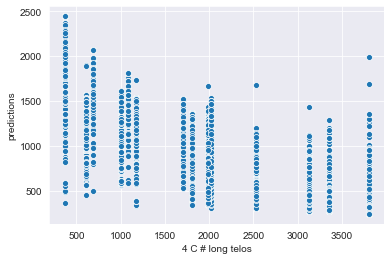

In [268]:
sns.scatterplot(x='4 C # long telos', y='predictions', data=combined)

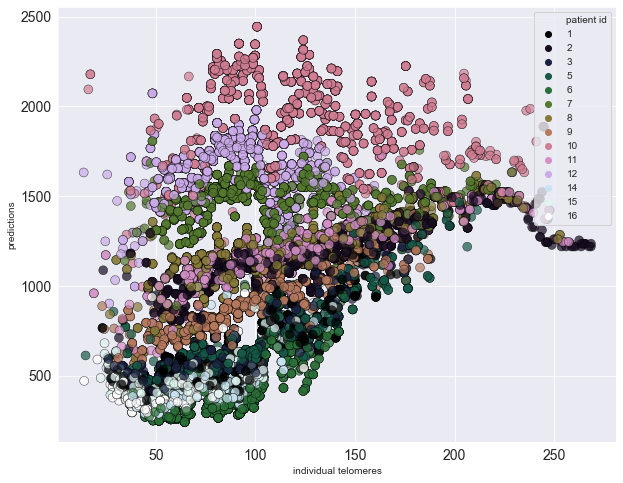

In [269]:
sns.set_color_codes()
plt.figure(figsize=(10,8))
ax = sns.scatterplot(x='individual telomeres', y='predictions', hue='patient id', data=combined, 
                     s=80, 
                     alpha=.7,
                     linewidth=.5, 
                     edgecolor='black',
                     legend='full', 
                     palette='cubehelix')

# ax.set_xlabel("Actual post-therapy mean telomere lengths", fontsize=14)
# ax.set_ylabel("Predicted post-therapy mean telomere lengths", fontsize=14)
ax.tick_params(labelsize=14)

## Dataframe for model metrics

In [307]:
telos_short_telos_rows = telo_row + short_telos_row + long_telos_row
stats_df = trp.make_stats_df(stats_list=telos_short_telos_rows)
stats_df

Model                                          Features  \
0  XGBoost  [individual telomeres, timepoint_2 irrad @ 4 Gy]   
1  XGBoost  [individual telomeres, timepoint_2 irrad @ 4 Gy]   
2  XGBoost  [individual telomeres, timepoint_2 irrad @ 4 Gy]   

              Target  Average MAE of CV folds  Std dev of MAE of CV folds  \
0     4 C telo means                   3.2051                      0.0565   
1  4 C # short telos                 235.9586                      1.9788   
2   4 C # long telos                 324.8429                      3.0600   

   MAE predicted vs. test values  R2 predicted vs. test values  \
0                         3.2038                        0.8874   
1                       231.9450                        0.8164   
2                       328.4998                        0.8232   

   N samples training data  
0                   103040  
1                   103040  
2                   103040

In [308]:
path=f'../graphs/paper figures/supp figs/ML models predicting #1 4 C telo means and #2 short telos and #3 long telos.png'
trp.df_to_png(df=stats_df, path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


# Machine Learning - exploring predictions of chromosome rearrangements

## Loading data & general cleaning

In [71]:
all_chr_aberr_df = pd.read_csv('../data/compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner())])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

## Train/test split 

In [72]:
chr_train, chr_test = train_test_split(cleaned_chr_df, test_size=0.2, shuffle=True, 
                                       stratify=cleaned_chr_df[['patient id', 'timepoint']])

In [183]:
# # testing if adding 1 to every observation/CA enhances ML.. (it doesn't)

# chr_train = chr_train.copy()
# for col in chr_train.columns:
#     if col != 'patient id' and col != 'timepoint':
#         chr_train[col] = chr_train[col] + 1
# #         chr_train[col] = np.log10(chr_train[col])
        
# chr_test = chr_test.copy()
# for col in chr_test.columns:
#     if col != 'patient id' and col != 'timepoint':
#         chr_test[col] = chr_test[col] + 1
# #         chr_test[col] = np.log10(chr_test[col])

## Initializing cleaning/model pipelines

In [57]:
features = ['# inversions']
target = '# inversions'

make_new_features_target = Pipeline([('make features', trp.make_chr_features(combine_inversions=True, 
                                                                             bool_features=False,
                                                                             features=features)),
                                     ('make target merge', trp.make_target_merge(target=target, features=features))])

In [58]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
chr_model = XGBRegressor(n_estimators=200, max_depth=15, learning_rate=0.1,
                         objective='reg:squarederror',
                         random_state=0,)

chr_xgb_pipe = Pipeline([('XGB', chr_model)
                        ])

chr_full_pipe = Pipeline([('make ftr target', make_new_features_target),
                          ('model', chr_model)
                         ])

In [59]:
cleaned_chr_train = chr_train.copy()
cleaned_chr_test = chr_test.copy()

cleaned_chr_train = make_new_features_target.fit_transform(cleaned_chr_train)
cleaned_chr_test = make_new_features_target.fit_transform(cleaned_chr_test)

## Cross validation; MAE & R2 score when predicting # of chr aberrations post-therapy (4 C)

In [60]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data; w/ model, predict y_test from X_test; score model by MAE/R2 - return model
chr_fit_xgb_model, row = trp.cv_score_fit_mae_test(train_set=cleaned_chr_train, test_set=cleaned_chr_test,
                                              model=chr_model, cv=5, target='4 C # inversions')

MAE per CV fold: 
[0.11672691 0.19840033 0.1643636  0.20224092 0.20403181] 

MEAN of MAE all folds: 0.17715271292656237
STD of MAE all folds: 0.03352075492010987

MAE of predict_y_test & y_test: 0.2753826078204882
R2 between predict_y_test & y_test: -0.02409218979297223


In [61]:
chr_y_predict, y_true, = trp.chr_aberr_predict_target_4C_compare_actual(cleaned_unsplit_chr_data=cleaned_chr_df, 
                                                                        cleaned_test_set=cleaned_chr_test, 
                                                                        model=chr_fit_xgb_model, target='4 C # inversions',
                                                                        clean_process_pipe=make_new_features_target, verbose=False)

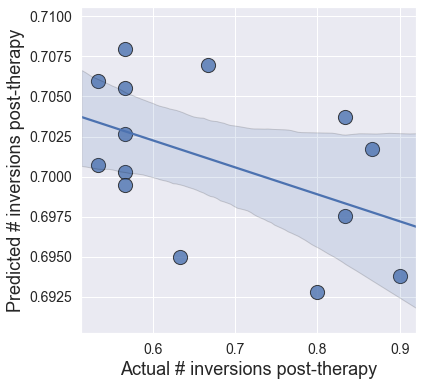

In [156]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=y_true, y=chr_y_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual # inversions post-therapy', fontsize=18)
ax.set_ylabel('Predicted # inversions post-therapy', fontsize=18)
ax.tick_params(labelsize=14)
# ax.set_title('Fig. 2', weight='bold', fontsize=20)

## Looping through all chr aberration types for XGBoost model fitting, creating dict for graphing & list for displaying model metrics

In [141]:
features_list = [['# inversions'], ['# translocations'], 
                 ['# dicentrics'], ['# excess chr fragments'],
                 ['# inversions', '# translocations', '# dicentrics', '# excess chr fragments']]

           
target1_list = ['# inversions', '# translocations', 
                '# dicentrics', '# excess chr fragments',
                'aberration index']

target2_list = ['4 C # inversions', '4 C # translocations', 
                '4 C # dicentrics', '4 C # excess chr fragments',
                '4 C aberration index']

stats_list = []
stats_list, graphing_dict = trp.script_load_clean_data_ml_pipeline_loop_aberrations(features_list=features_list,
                                                                                    target1_list=target1_list,
                                                                                    target2_list=target2_list,
                                                                                    stats_list=stats_list,
                                                                                    verbose=False)

## Displaying model metrics in dataframe & graphing performance

In [142]:
import copy

stats_list_copy = copy.deepcopy(stats_list)
n_rows = cleaned_chr_train.shape[0]

for row in stats_list_copy:
    row.append(n_rows)

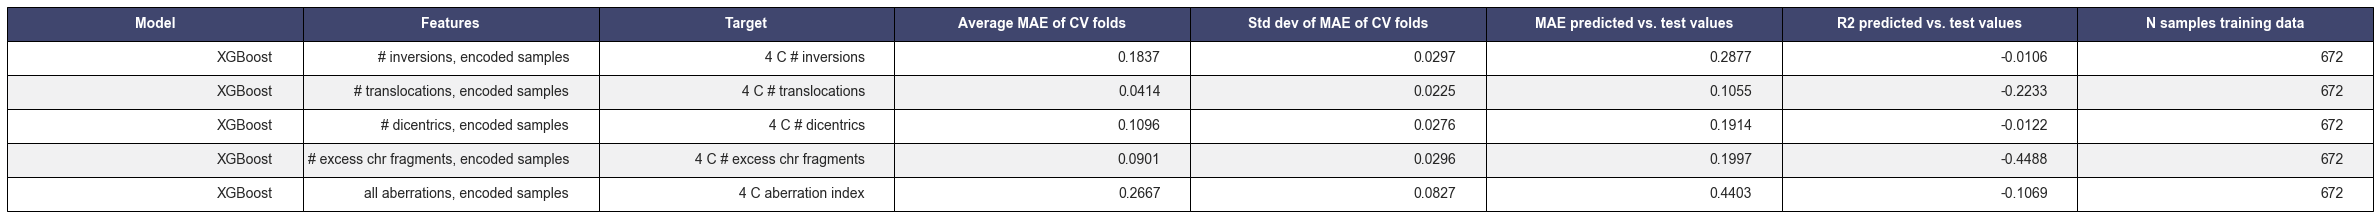

In [143]:
# saving df of model metrics for chr aberr models

graphing_df = trp.make_graphing_df(graphing_dict=graphing_dict)
stats_df = trp.make_stats_df(stats_list=stats_list_copy)
stats_df['Features'] = stats_df['Features'].apply(lambda row: ', '.join(row))

stats_df.iloc[0, 1] = '# inversions, encoded samples'
stats_df.iloc[1, 1] = '# translocations, encoded samples'
stats_df.iloc[2, 1] = '# dicentrics, encoded samples'
stats_df.iloc[3, 1] = '# excess chr fragments, encoded samples'
stats_df.iloc[4, 1] = 'all aberrations, encoded samples'
# display(stats_df)

path=f'../graphs/paper figures/supp figs/2 ML models metrics for all chr aberration types.png'
trp.render_mpl_table(stats_df, col_width=5.3, path=path)

In [123]:
# saving df of model metrics for all models
all_rows = telo_row + short_telos_row + stats_list_copy
stats_df = trp.make_stats_df(stats_list=all_rows)

path=f'../graphs/paper figures/supp figs/ML model metrics for all telo and chr aberr endpoints.png'
trp.df_to_png(df=stats_df, path=path)

NameError: name 'telo_row' is not defined

In [161]:
graphing_df.rename({'predicted values':'Predicted values',
                    'actual values':'Actual values'}, axis=1, inplace=True)

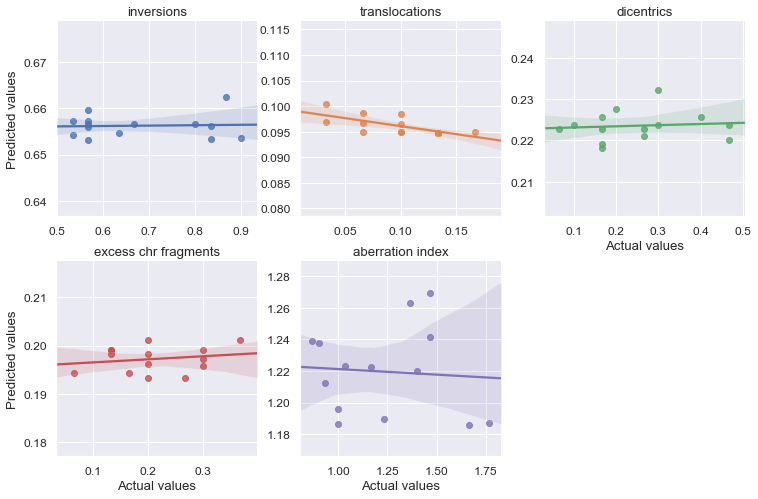

In [163]:
ax = sns.set(font_scale=1.1)
ax = sns.lmplot(x='Actual values', y='Predicted values', col='aberration type', hue='aberration type',
                col_order=['# inversions', '# translocations', 
                           '# dicentrics', '# excess chr fragments', 'aberration index'],
                sharex=False, sharey=False, col_wrap=3, data=graphing_df, height=3.5)

ax_list = ax.axes
ax_list[0].set_title('inversions')
ax_list[1].set_title('translocations')
ax_list[2].set_title('dicentrics')
ax_list[3].set_title('excess chr fragments')
ax_list[4].set_title('aberration index')

plt.tight_layout(pad=.7)
plt.savefig(f'../graphs/paper figures/supp figs/ML models performance for all chr aberr types.png',
            dpi=400, bbox_iches='tight')

## Making dataframes showing chr aberr data setup

In [129]:
features = ['# inversions', '# translocations', '# dicentrics', '# excess chr fragments']
target = 'aberration index'

# features = ['# inversions']
# target = '# inversions'

make_new_features_target = Pipeline([('make features', trp.make_chr_features(combine_inversions=True, 
                                                                             bool_features=False,
                                                                             features=features)),
                                     ('make target merge', trp.make_target_merge(target=target, features=features))])

In [130]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
chr_model = XGBRegressor(n_estimators=200, max_depth=15, learning_rate=0.1,
                         objective='reg:squarederror',
                         random_state=0,)

chr_xgb_pipe = Pipeline([('XGB', chr_model)
                        ])

chr_full_pipe = Pipeline([('make ftr target', make_new_features_target),
                          ('model', chr_model)
                         ])

## Cleaning/modeling data with pipeline

In [131]:
cleaned_chr_train = chr_train.copy()
cleaned_chr_test = chr_test.copy()

cleaned_chr_train = make_new_features_target.fit_transform(cleaned_chr_train)
cleaned_chr_test = make_new_features_target.fit_transform(cleaned_chr_test)

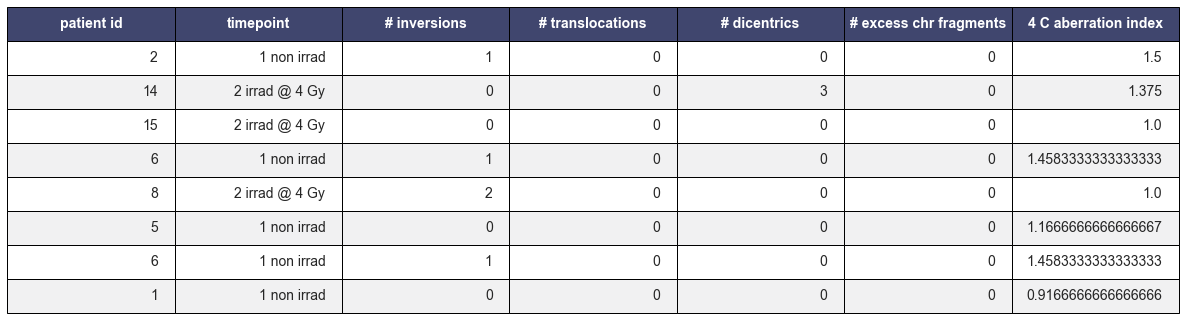

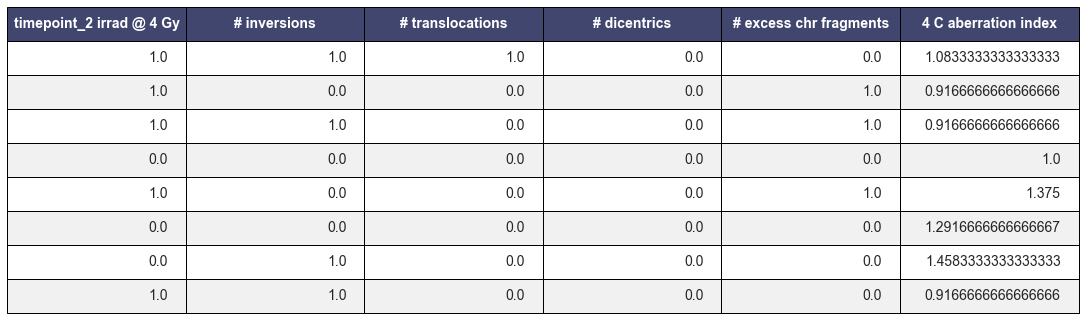

In [132]:
# aberration index

test_viz_post = cleaned_chr_train[['timepoint_2 irrad @ 4 Gy', '# inversions', '# translocations', 
                                   '# dicentrics', '# excess chr fragments', '4 C aberration index']]

test_viz_pre = chr_train[['patient id', 'timepoint', '# inversions', '# translocations', 
                          '# dicentrics', '# excess chr fragments',]]

test_viz_PRE = (test_viz_pre[test_viz_pre['timepoint'].isin(['1 non irrad', '2 irrad @ 4 Gy'])]
                .merge(cleaned_chr_train[['patient id', '4 C aberration index']])
                .sort_values(by=['patient id', 'timepoint'])
                .reset_index(drop=True))

path=f'../graphs/paper figures/supp figs/example view ALL chr aberr PRE CLEAN dataframe for ML.png'
trp.render_mpl_table(test_viz_PRE.sample(8).reset_index(drop=True), col_width=3, path=path)
path=f'../graphs/paper figures/supp figs/example view ALL chr aberr POST CLEAN dataframe for ML.png'
trp.render_mpl_table(test_viz_post.sample(8).reset_index(drop=True), col_width=3.2, path=path)

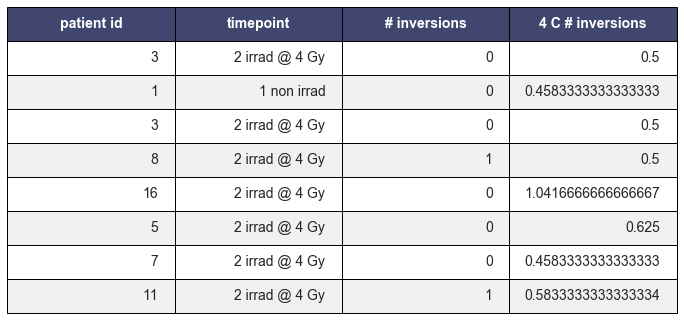

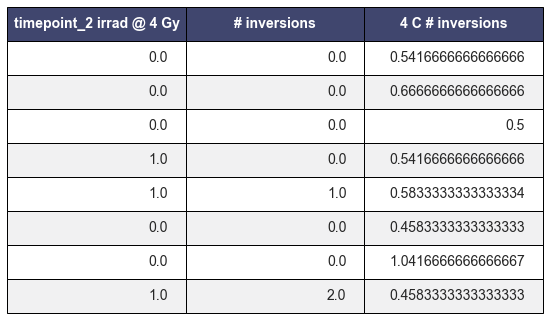

In [128]:
# inversions

test_viz_post = cleaned_chr_train[['timepoint_2 irrad @ 4 Gy', '# inversions', 
                                   '4 C # inversions']]

test_viz_pre = chr_train[['patient id', 'timepoint', '# inversions']]

test_viz_PRE = (test_viz_pre[test_viz_pre['timepoint'].isin(['1 non irrad', '2 irrad @ 4 Gy'])]
                .merge(cleaned_chr_train[['patient id', '4 C # inversions']])
                .sort_values(by=['patient id', 'timepoint'])
                .reset_index(drop=True))

path=f'../graphs/paper figures/supp figs/example view INVERSIONS PRE CLEAN chr aberr dataframe for ML.png'
trp.render_mpl_table(test_viz_PRE.sample(8).reset_index(drop=True), col_width=3, path=path)
path=f'../graphs/paper figures/supp figs/example view INVERSIONS POST CLEAN chr aberr dataframe for ML.png'
trp.render_mpl_table(test_viz_post.sample(8).reset_index(drop=True), col_width=3.2, path=path)

# Clustering telomere data

## Mean telomere length (teloFISH)

In [366]:
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')
means = all_patients_df.drop(['telo data', 'Q1', 'Q2-3', 'Q4'], axis=1)

In [367]:
pivot = means.pivot_table(index=['patient id'], columns='timepoint', values='telo means').reset_index()
pivot.columns.name = ''

pivot = pivot[pivot['patient id'] != 13].copy()
pivot.set_index(pivot['patient id'], inplace=True)
pivot.drop(['patient id'], axis=1, inplace=True)

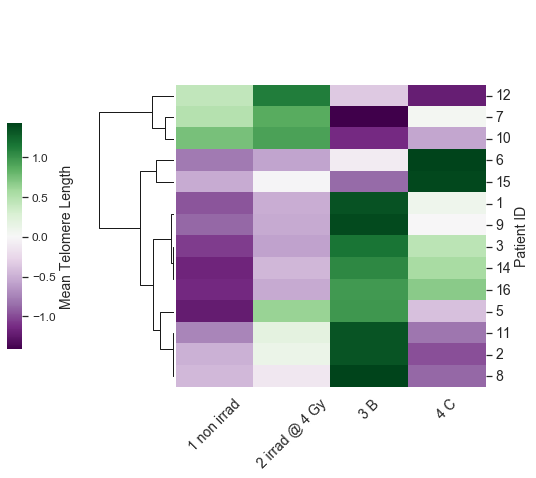

In [524]:
g = sns.clustermap(pivot, method='single', metric='correlation',
                   z_score=0, figsize=(7,7), cmap='PRGn',
#                    standard_scale=0, 
                   col_cluster=False,
                   cbar_kws={},) 
font_size=14

# colorbar 
g.cax.set_position([-0.05, .2, .03, .45])
g.cax.set_ylabel('Mean Telomere Length', rotation=90, fontsize=font_size)
g.cax.tick_params(labelsize=12)

# modifying y axis
g.ax_heatmap.set_ylabel('Patient ID', fontsize=font_size)
labels = g.ax_heatmap.yaxis.get_majorticklabels()
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=font_size)
plt.setp(g.ax_heatmap.yaxis.get_minorticklabels(), fontsize=font_size)
g.ax_heatmap.set_yticklabels(labels, rotation=0, fontsize=font_size, va="center")

# modifying x axis
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize=font_size)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)

plt.savefig('../graphs/paper figures/main figs/CLUSTERING heatmap all patient by mean telomere length means teloFISH.png', 
            dpi=400, bbox_inches = "tight")

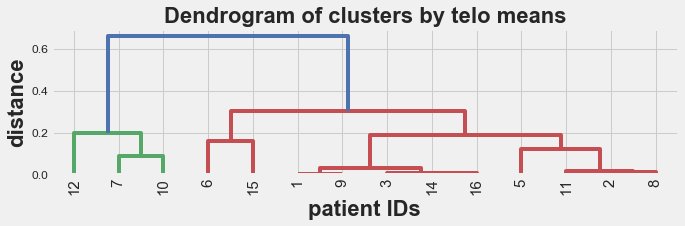

0 Cluster number 2 has 11 elements
1 Cluster number 1 has 3 elements


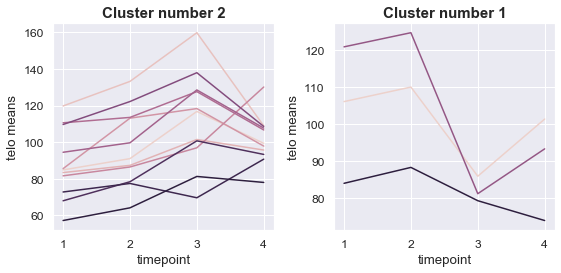

In [368]:
clustered_telos = trp.cluster_data_return_df(means, target='telo means', cut_off_n=2,
                                             metric='correlation', method='single',
                                             x_size=8, y_size=4)

In [387]:
clustered_telos.dtypes

patient id                     int64
telo means cluster groups      int32
timepoint                     object
telo means                   float64
dtype: object

In [388]:
asd = clustered_telos[['patient id', 'timepoint', 'telo means cluster groups']].merge(cleaned_chr_df, on=['patient id', 'timepoint'])
asd['# inversions'] = asd['# inversions'] + asd['# terminal inversions']
asd['telo means cluster groups'] = asd['telo means cluster groups'].astype('str')
asd.head()

patient id    timepoint telo means cluster groups  # inversions  \
0           1  1 non irrad                         2             0   
1           1  1 non irrad                         2             1   
2           1  1 non irrad                         2             0   
3           1  1 non irrad                         2             0   
4           1  1 non irrad                         2             0   

   # terminal inversions  # sister chromatid exchanges  # dicentrics  \
0                      0                             1             0   
1                      1                             2             0   
2                      0                             0             0   
3                      0                             0             0   
4                      0                             1             0   

   # excess chr fragments  # sat associations  # terminal SCEs  \
0                       0                   0                0   
1                       0                   1                0   
2                       0                   1                1   
3                       0                   0                1   
4                       0                   0                0   

   # translocations  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

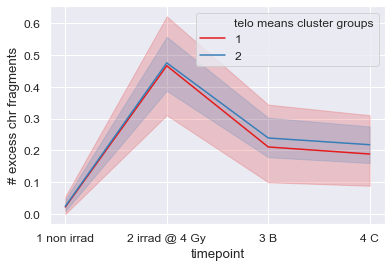

In [391]:
sns.lineplot(x='timepoint', y='# excess chr fragments', hue='telo means cluster groups', 
             palette=sns.color_palette("Set1", asd['telo means cluster groups'].nunique()), data=asd)

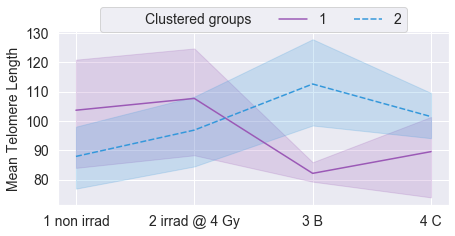

In [340]:
clustered_graphing = clustered_telos.rename({'telo means cluster groups': 'Clustered groups'}, axis=1).copy()

trp.graph_cluster_groups(clustered_graphing, target='telo means', hue='Clustered groups')

In [235]:
df = clustered_graphing[clustered_graphing['Clustered groups'] == 1] 

trp.telos_scipy_anova_post_hoc_tests(df0=df, time_col='timepoint', target='telo means',
                                     sig_test=stats.f_oneway, post_hoc='tukeyHSD', repeated_measures=True)

REPEATED MEASURES ANOVA for telomere length: 0.04395417105675324
      Multiple Comparison of Means - Tukey HSD,FWER=0.05      
    group1         group2     meandiff  lower    upper  reject
--------------------------------------------------------------
 1 non irrad   2 irrad @ 4 Gy  4.0158  -34.9883 43.0199 False 
 1 non irrad        3 B       -21.5157 -60.5198 17.4884 False 
 1 non irrad        4 C       -14.1147 -53.1189 24.8894 False 
2 irrad @ 4 Gy      3 B       -25.5315 -64.5356 13.4726 False 
2 irrad @ 4 Gy      4 C       -18.1306 -57.1347 20.8736 False 
     3 B            4 C        7.401   -31.6032 46.4051 False 
--------------------------------------------------------------


telo means CLUSTER 1 | patient IDs: [7, 10, 12]
telo means CLUSTER 2 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]


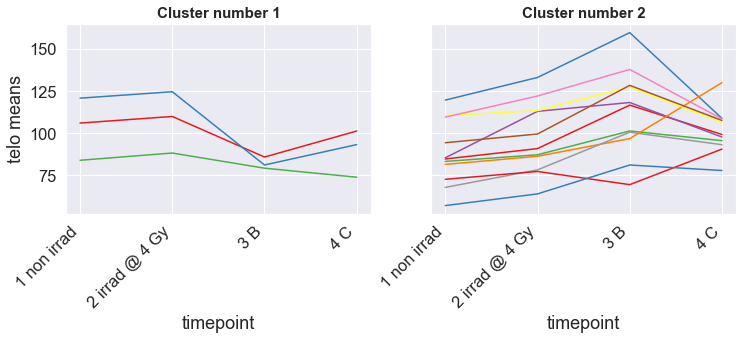

In [25]:
trp.graph_clusters_per_patient(clustered_telos, target='telo means',
                               y_dimen=1, x_dimen=2,
                               fsize=(12,3.5))

## Short telomeres

In [325]:
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')
short_telos = all_patients_df.drop(['telo data', 'Q2-3', 'Q4', 'telo means'], axis=1)
short_telos.rename(columns={'Q1': 'Number of short telomeres'}, inplace=True)

In [326]:
pivot1 = short_telos.pivot_table(index=['patient id'], columns='timepoint', values='Number of short telomeres').reset_index()
pivot1.columns.name = ''

pivot1 = pivot1[pivot1['patient id'] != 13].copy()
pivot1.set_index(pivot1['patient id'], inplace=True)
pivot1.drop(['patient id'], axis=1, inplace=True)

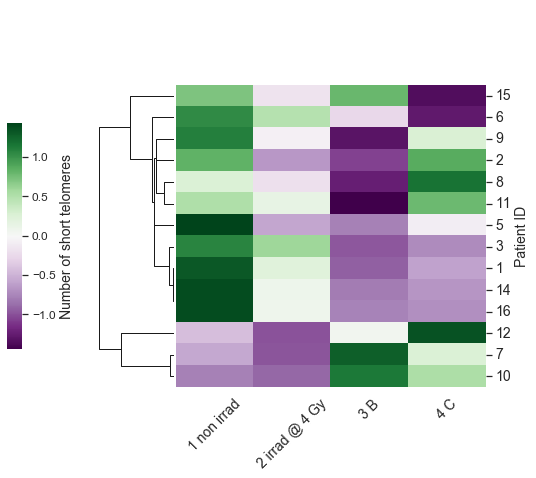

In [327]:
g = sns.clustermap(pivot1, method='single', metric='correlation',
                   z_score=0, figsize=(7,7), cmap='PRGn',
#                    standard_scale=0, 
                   col_cluster=False,
                   cbar_kws={},) 
font_size=14

# colorbar 
g.cax.set_position([-0.05, .2, .03, .45])
g.cax.set_ylabel('Number of short telomeres', rotation=90, fontsize=font_size)
g.cax.tick_params(labelsize=12)

# modifying y axis
g.ax_heatmap.set_ylabel('Patient ID', fontsize=font_size)
labels = g.ax_heatmap.yaxis.get_majorticklabels()
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=font_size)
plt.setp(g.ax_heatmap.yaxis.get_minorticklabels(), fontsize=font_size)
g.ax_heatmap.set_yticklabels(labels, rotation=0, fontsize=font_size, va="center")

# modifying x axis
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize=font_size)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)

plt.savefig('../graphs/paper figures/main figs/CLUSTERING heatmap all patient by short telomeres teloFISH.png', 
            dpi=400, bbox_inches = "tight")

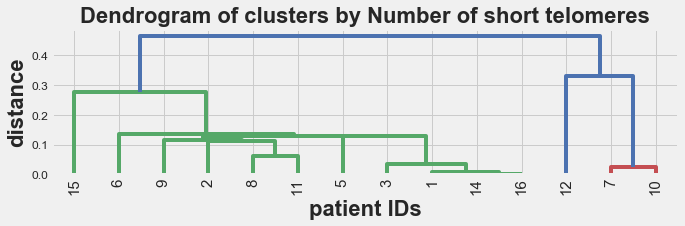

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


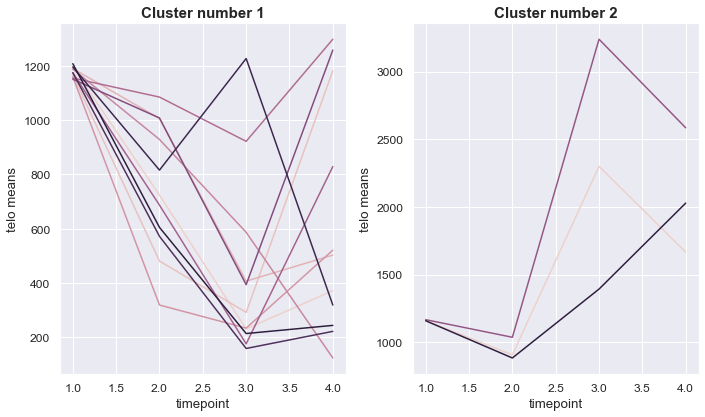

In [328]:
clustered_short_telos = trp.cluster_data_return_df(short_telos, target='Number of short telomeres', cut_off_n=2)

In [329]:
clustered_short_telos['Clustered groups'] = (clustered_short_telos['Number of short telomeres cluster groups']
                                                             .apply(lambda row: trp.swap_short_telos_group_number(row)))

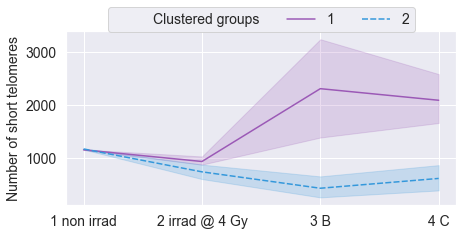

In [332]:
trp.graph_cluster_groups(clustered_short_telos, target='Number of short telomeres', hue='Clustered groups')

# short telomeres CLUSTER 1 | patient IDs: [7, 10, 12]
# short telomeres CLUSTER 2 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]


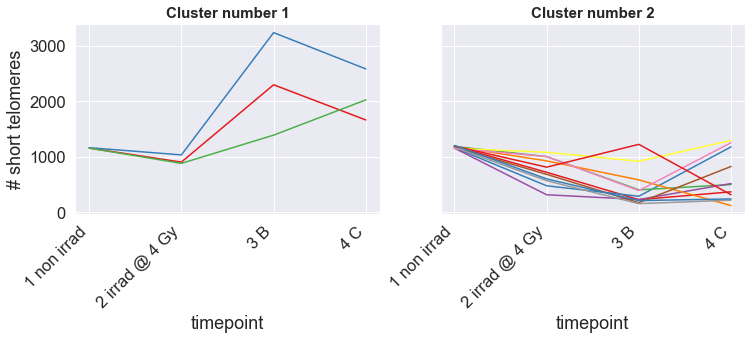

In [31]:
trp.graph_clusters_per_patient(clustered_short_telos, target='# short telomeres',
                               y_dimen=1, x_dimen=2, fsize=(12, 3.5))

Clustering analysis by hierarchical clustering of longitudinal changes in mean telomere length and number of short telomeres in the patients yielded 4 groups in each case, distinguishable by differential responses to radiation therapy. When patients were clustered by mean telomere length or number of short telomeres, the clustered groups differed by only one patient, suggesting strong agreement between mean telomere length and number of short telomeres for data clustering. 

## Combining cluster groups of means + short telos

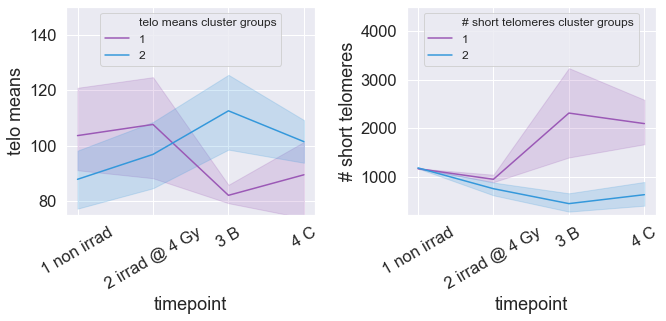

In [33]:
y_list = ['telo means', '# short telomeres']
hue_list = ['telo means cluster groups', '# short telomeres cluster groups']
df_list = [clustered_telos, clustered_short_telos]
ylim_dict = {'telo means': (75, 150),
             '# short telomeres': (200, 4500)}

trp.plot_multiple_types_clusters(y_list=y_list, hue_list=hue_list,
                                 df_list=df_list, ylim_dict=ylim_dict)

## Long telomeres

In [310]:
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')
long_telos = all_patients_df.drop(['telo data', 'Q1', 'Q2-3', 'telo means'], axis=1)
long_telos.rename(columns={'Q4': 'Number of long telomeres'}, inplace=True)

In [312]:
pivot2 = long_telos.pivot_table(index=['patient id'], columns='timepoint', values='Number of long telomeres').reset_index()
pivot2.columns.name = ''

pivot2 = pivot2[pivot2['patient id'] != 13].copy()
pivot2.set_index(pivot2['patient id'], inplace=True)
pivot2.drop(['patient id'], axis=1, inplace=True)

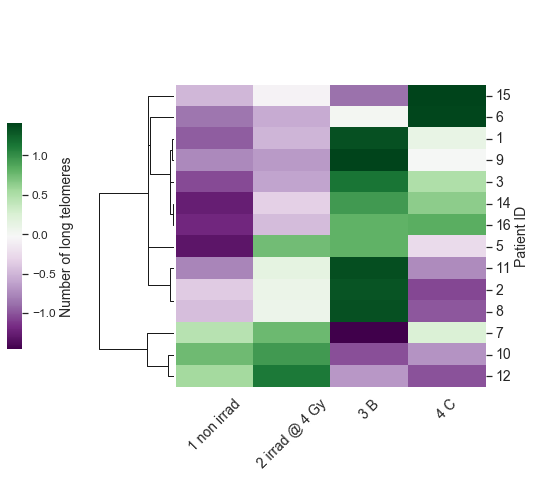

In [313]:
g = sns.clustermap(pivot2, method='single', metric='correlation',
                   z_score=0, figsize=(7,7), cmap='PRGn',
#                    standard_scale=0, 
                   col_cluster=False,
                   cbar_kws={},) 
font_size=14

# colorbar 
g.cax.set_position([-0.05, .2, .03, .45])
g.cax.set_ylabel('Number of long telomeres', rotation=90, fontsize=font_size)
g.cax.tick_params(labelsize=12)

# modifying y axis
g.ax_heatmap.set_ylabel('Patient ID', fontsize=font_size)
labels = g.ax_heatmap.yaxis.get_majorticklabels()
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=font_size)
plt.setp(g.ax_heatmap.yaxis.get_minorticklabels(), fontsize=font_size)
g.ax_heatmap.set_yticklabels(labels, rotation=0, fontsize=font_size, va="center")

# modifying x axis
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize=font_size)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)

plt.savefig('../graphs/paper figures/main figs/CLUSTERING heatmap all patient by long telomeres teloFISH.png', 
            dpi=400, bbox_inches = "tight")

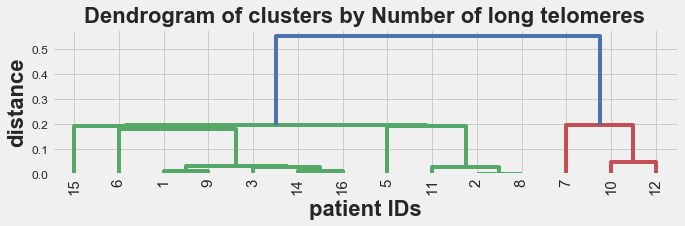

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


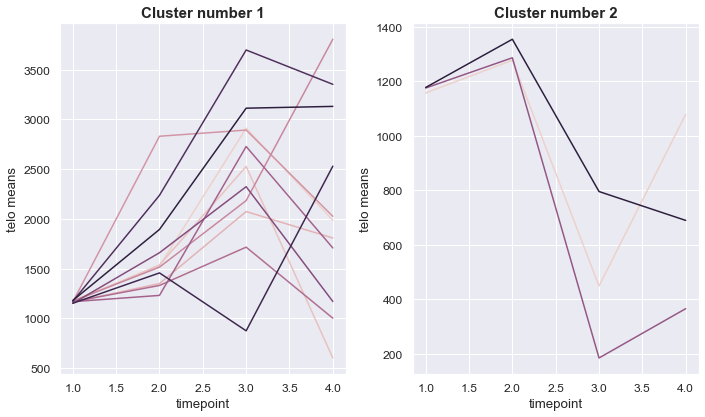

In [314]:
clustered_long_telos = trp.cluster_data_return_df(long_telos, target='Number of long telomeres', cut_off_n=2)

In [317]:
clustered_long_telos['Clustered groups'] = (clustered_long_telos['Number of long telomeres cluster groups']
                                                             .apply(lambda row: trp.swap_short_telos_group_number(row)))

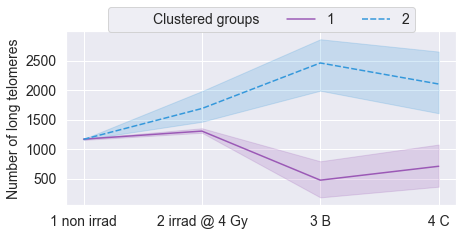

In [342]:
trp.graph_cluster_groups(clustered_long_telos, target='Number of long telomeres', hue='Clustered groups')

Number of long telomeres CLUSTER 1 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]
Number of long telomeres CLUSTER 2 | patient IDs: [7, 10, 12]


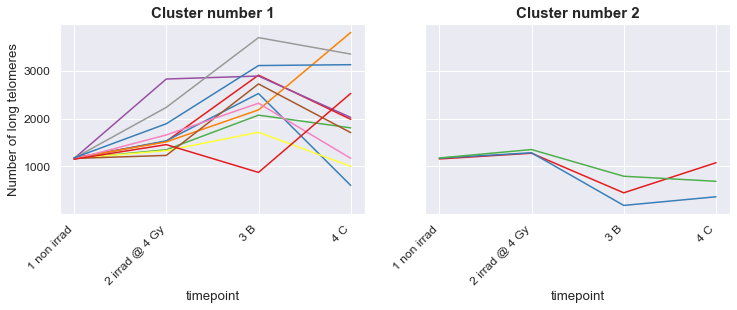

In [322]:
trp.graph_clusters_per_patient(clustered_long_telos, target='Number of long telomeres',
                               y_dimen=1, x_dimen=2, fsize=(12, 3.5))

## Mean telomere length (qPCR)

In [64]:
all_qPCR_df = pd.read_csv('../qPCR telo data/all_qPCR_df.csv')
means_qPCR = all_qPCR_df.drop(['SEM'], axis=1)
means_qPCR['timepoint'] = means_qPCR['timepoint'].apply(lambda row: trp.encode_timepts(row))
means_qPCR.head()

patient id  timepoint  telo means qPCR
0           1          1         2.182028
1           1          3         1.964348
2           1          4         1.749799
3           2          1         1.669445
4           2          3         1.780092

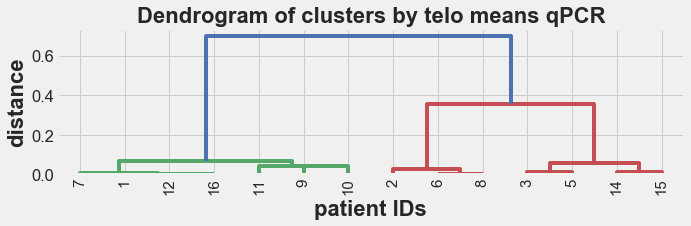

0 Cluster number 1 has 7 elements
1 Cluster number 2 has 7 elements


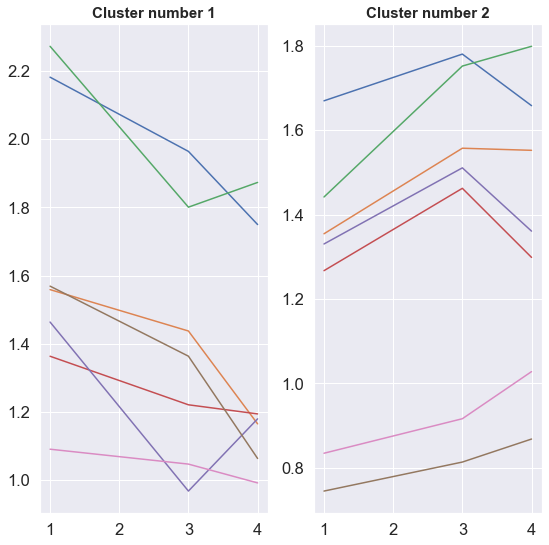

In [65]:
clustered_qPCR = trp.cluster_data_return_df(means_qPCR, target='telo means qPCR', cut_off_n=2,
                                            y_size=9, x_size=9)

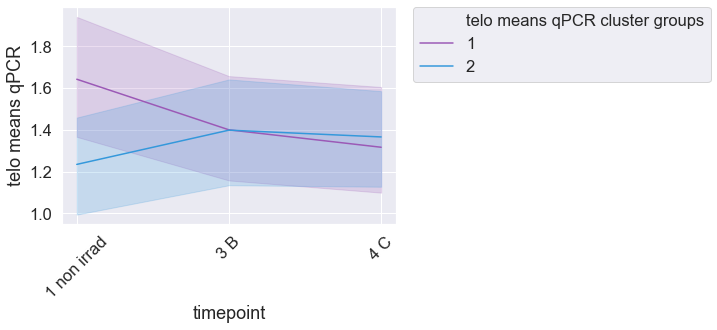

In [66]:
trp.graph_cluster_groups(clustered_qPCR, target='telo means qPCR', hue='telo means qPCR cluster groups')

# Clustering chromosome rearrangement data

In [36]:
all_chr_aberr_df = pd.read_csv('../data/compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False)),
                            ('features', trp.make_chr_features(combine_inversions=True))
                           ])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)
mean_chr = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()

In [37]:
mean_chr.head()

patient id       timepoint  # inversions  # sister chromatid exchanges  \
0           1     1 non irrad      0.233333                      0.633333   
1           1  2 irrad @ 4 Gy      0.766667                      0.800000   
2           1             3 B      1.266667                      0.700000   
3           1             4 C      0.566667                      0.933333   
4           2     1 non irrad      0.300000                      0.533333   

   # dicentrics  # excess chr fragments  # sat associations  # terminal SCEs  \
0      0.000000                0.000000            0.133333         0.566667   
1      0.400000                0.366667            0.033333         0.666667   
2      0.366667                0.433333            0.766667         0.800000   
3      0.066667                0.266667            0.366667         0.766667   
4      0.000000                0.033333            0.333333         0.766667   

   # translocations  
0          0.033333  
1          0.133333  
2          0.100000  
3          0.133333  
4          0.033333

## Testing cluster functions on inversions / excess chr fragments

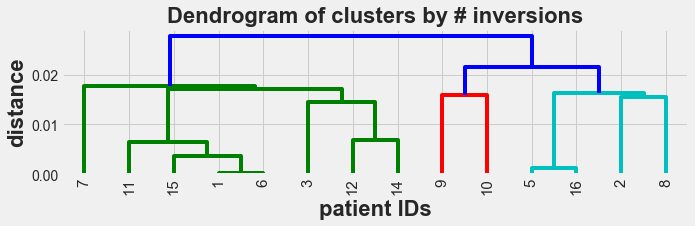

0 Cluster number 1 has 8 elements
1 Cluster number 2 has 6 elements


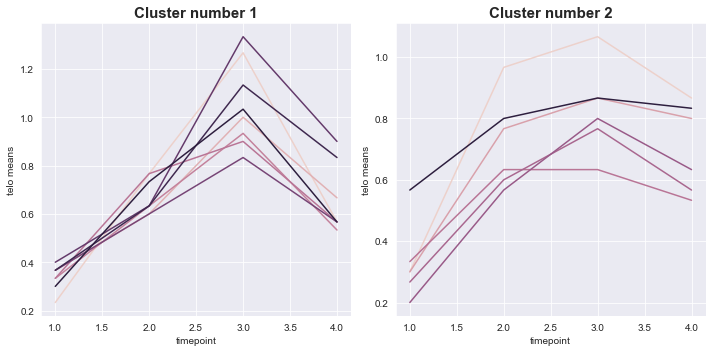

In [38]:
clustered_invs = trp.cluster_data_return_df(mean_chr, target='# inversions', cut_off_n=2,
                                            y_size=5, x_size=10)

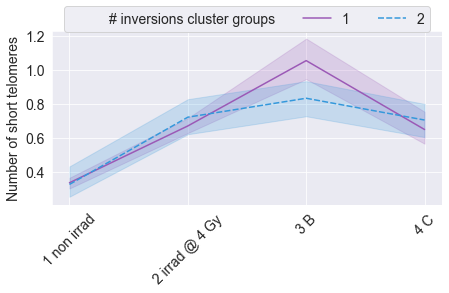

In [39]:
trp.graph_cluster_groups(clustered_invs, target='# inversions', hue='# inversions cluster groups')

# inversions CLUSTER 1 | patient IDs: [1, 3, 6, 7, 11, 12, 14, 15]
# inversions CLUSTER 2 | patient IDs: [2, 5, 8, 9, 10, 16]


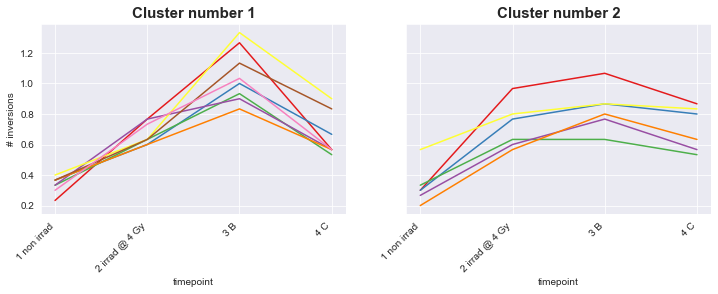

In [40]:
trp.graph_clusters_per_patient(clustered_invs, target='# inversions', y_dimen=1, x_dimen=2, fsize=(12,3.5))

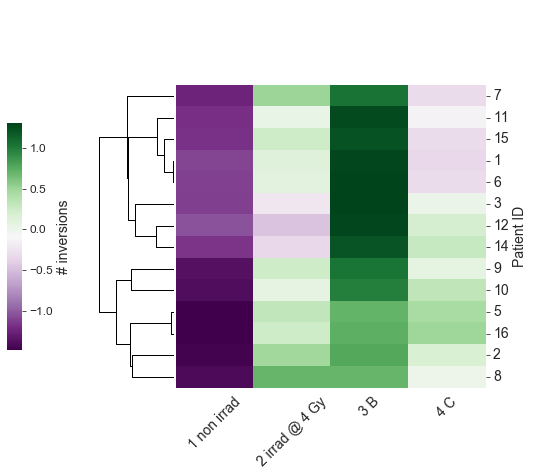

In [41]:
trp.make_clustered_heatmap(df=mean_chr, target='# inversions', cb_target_label='# inversions')

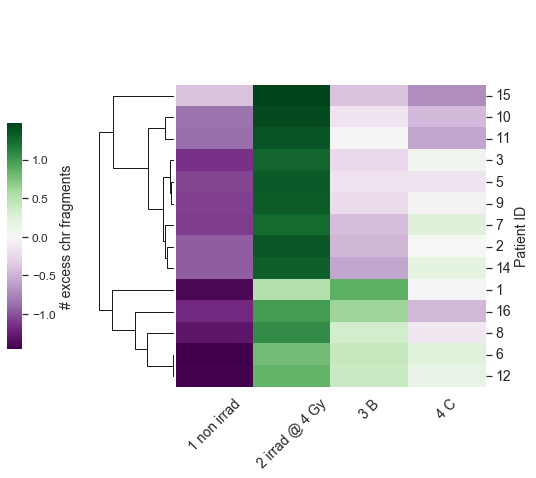

In [609]:
trp.make_clustered_heatmap(df=mean_chr, target='# excess chr fragments', cb_target_label='# excess chr fragments')

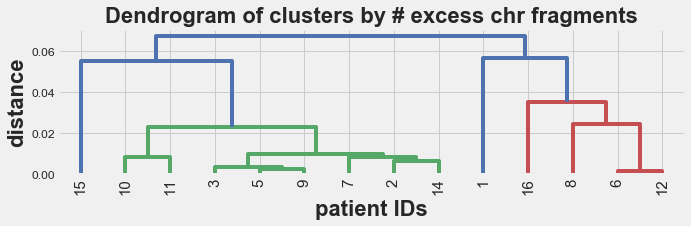

0 Cluster number 2 has 5 elements
1 Cluster number 1 has 9 elements
# excess chr fragments CLUSTER 1 | patient IDs: [2, 3, 5, 7, 9, 10, 11, 14, 15]
# excess chr fragments CLUSTER 2 | patient IDs: [1, 6, 8, 12, 16]


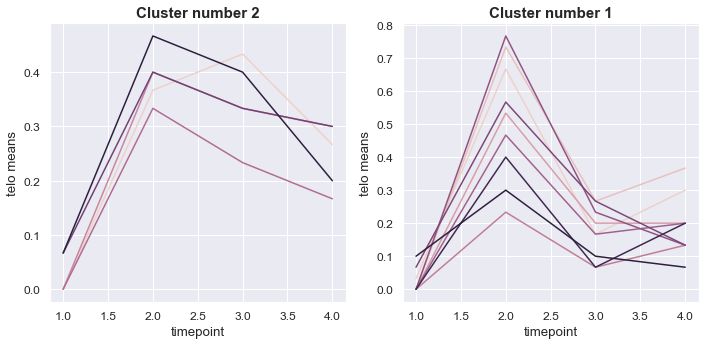

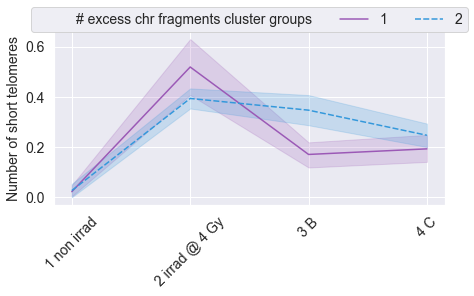

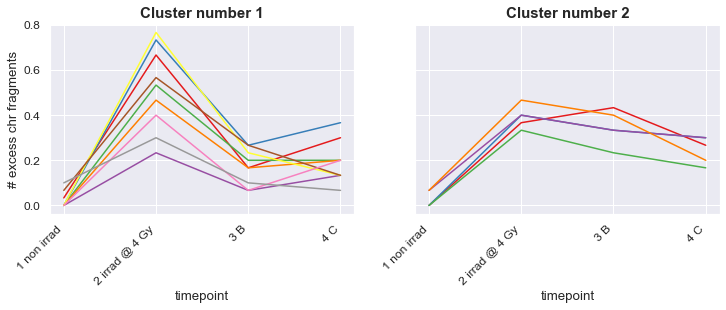

In [508]:
target = '# excess chr fragments'

clustered_invs = trp.cluster_data_return_df(mean_chr, target=target, cut_off_n=2, y_size=5, x_size=10)
trp.graph_cluster_groups(clustered_invs, target=target, hue=f'{target} cluster groups')
trp.graph_clusters_per_patient(clustered_invs, target=target, y_dimen=1, x_dimen=2, fsize=(12,3.5))

## Looping through all clustered groups graphs

In [71]:
# chr_aberr = ['# inversions', '# terminal inversions', '# translocations', '# dicentrics']

# for target in chr_aberr:
#     if target == '# inversions':
#         n = 2
#     else:
#         n = 1
#     clustered = trp.cluster_data_return_df(mean_chr, target=target, cut_off_n=n)
#     trp.graph_cluster_groups(clustered, target=target, hue=f'{target} cluster groups')
#     trp.graph_clusters_per_patient(clustered, target=target, y_dimen=1, x_dimen=2, fsize=(12,3.5))

## Graphing all aberration cluster groups at once

In [42]:
mean_chr['aberration index'] = (mean_chr['# inversions'] + mean_chr['# translocations'] + 
                                mean_chr['# dicentrics'] + mean_chr['# excess chr fragments'])

In [43]:
mean_chr.head()

patient id       timepoint  # inversions  # sister chromatid exchanges  \
0           1     1 non irrad      0.233333                      0.633333   
1           1  2 irrad @ 4 Gy      0.766667                      0.800000   
2           1             3 B      1.266667                      0.700000   
3           1             4 C      0.566667                      0.933333   
4           2     1 non irrad      0.300000                      0.533333   

   # dicentrics  # excess chr fragments  # sat associations  # terminal SCEs  \
0      0.000000                0.000000            0.133333         0.566667   
1      0.400000                0.366667            0.033333         0.666667   
2      0.366667                0.433333            0.766667         0.800000   
3      0.066667                0.266667            0.366667         0.766667   
4      0.000000                0.033333            0.333333         0.766667   

   # translocations  aberration index  
0          0.033333          0.266667  
1          0.133333          1.666667  
2          0.100000          2.166667  
3          0.133333          1.033333  
4          0.033333          0.366667

In [54]:
# initializing list of aberrations to cluster by
y_list = ['# inversions', 
          '# translocations', 
          '# dicentrics',
          '# excess chr fragments',
          'aberration index']

# initializing list of dfs bearing clustered groups
inv_df = trp.cluster_data_return_df(mean_chr, target='# inversions', cut_off_n=2, verbose=False)
trans_df = trp.cluster_data_return_df(mean_chr, target='# translocations', cut_off_n=1, verbose=False)
dicent_df = trp.cluster_data_return_df(mean_chr, target='# dicentrics', cut_off_n=1, verbose=False)
chr_frag_df = trp.cluster_data_return_df(mean_chr, target='# excess chr fragments', cut_off_n=2, verbose=False)
aberr_index_df = trp.cluster_data_return_df(mean_chr, target='aberration index', cut_off_n=1, verbose=False)

df_list = [inv_df,
           trans_df, 
           dicent_df,
           chr_frag_df,
           aberr_index_df]

# hues to graph by
hue_list = ['# inversions cluster groups',
            '# translocations cluster groups', 
            '# dicentrics cluster groups',
            '# excess chr fragments cluster groups',
            'aberration index cluster groups']

# dimensions for each aberration
ylim_dict = {'# inversions': (.1, 1.7),
             '# translocations': (0, .4),
             '# dicentrics': (0, 1),
             '# excess chr fragments': (0, .95),
             'aberration index': (.2, 3)}

In [57]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


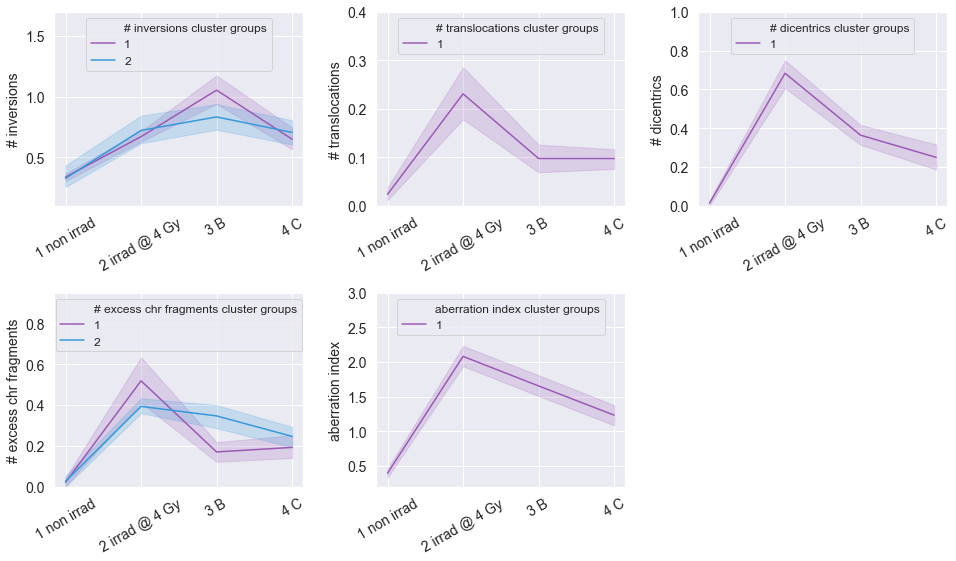

In [58]:
trp.plot_multiple_types_clusters(y_list=y_list, hue_list=hue_list,
                                 df_list=df_list, ylim_dict=ylim_dict)

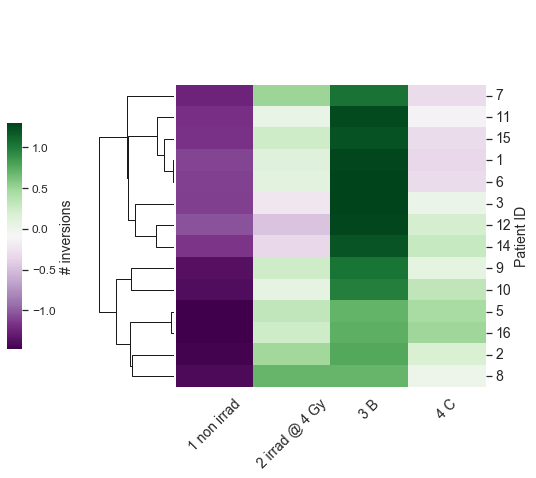

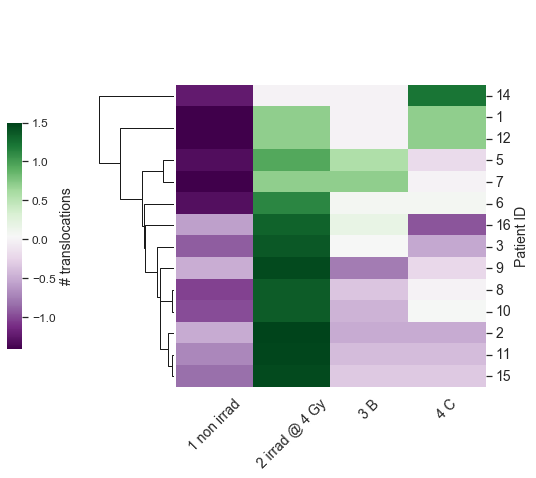

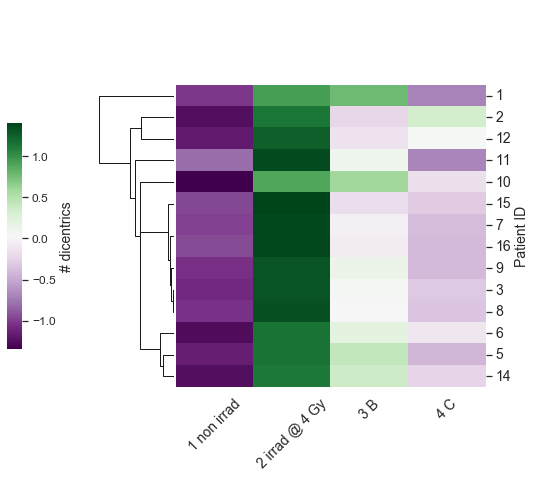

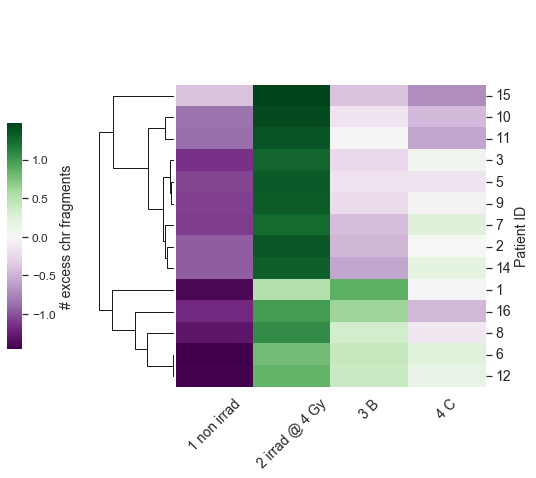

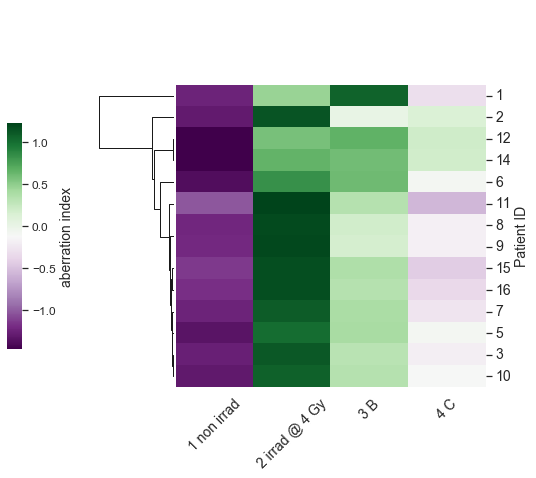

In [59]:
aberr_list = ['# inversions', '# translocations', 
              '# dicentrics', '# excess chr fragments', 'aberration index']

for aberr in aberr_list:
    trp.make_clustered_heatmap(df=mean_chr, target=aberr, cb_target_label=aberr)

# Exploratory analysis of telomere data and chromosome aberrations

In [351]:
all_patients_df.head()

patient id       timepoint  \
0           1     1 non irrad   
1           1  2 irrad @ 4 Gy   
2           1             3 B   
3           1             4 C   
4           2     1 non irrad   

                                           telo data  telo means    Q1  Q2-3  \
0  [70.74301669292741, 91.86033510872664, 59.1284...   84.796483  1195  2225   
1  [91.86033510872664, 119.31165592077517, 99.251...   90.975826   724  2350   
2  [191.10982054566642, 141.48603338585482, 114.0...  116.779989   231  1457   
3  [86.58100550477684, 139.3729078012595, 99.2504...   99.346299   372  2241   
4  [149.47242207268806, 104.23734697174298, 171.1...  119.773675  1166  2270   

     Q4  
0  1180  
1  1526  
2  2912  
3  1987  
4  1164

In [363]:
all_chr_aberr_df = pd.read_csv('../data/compiled patient data csv files/all_chr_aberr_df.csv')
general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False))])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

In [364]:
combined = all_patients_df.merge(cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean'), on=['patient id', 'timepoint'])
combined.head(4)

patient id       timepoint  \
0           1     1 non irrad   
1           1  2 irrad @ 4 Gy   
2           1             3 B   
3           1             4 C   

                                           telo data  telo means    Q1  Q2-3  \
0  [70.74301669292741, 91.86033510872664, 59.1284...   84.796483  1195  2225   
1  [91.86033510872664, 119.31165592077517, 99.251...   90.975826   724  2350   
2  [191.10982054566642, 141.48603338585482, 114.0...  116.779989   231  1457   
3  [86.58100550477684, 139.3729078012595, 99.2504...   99.346299   372  2241   

     Q4  # inversions  # terminal inversions  # sister chromatid exchanges  \
0  1180      0.066667               0.166667                      0.633333   
1  1526      0.466667               0.300000                      0.800000   
2  2912      0.800000               0.466667                      0.700000   
3  1987      0.300000               0.266667                      0.933333   

   # dicentrics  # excess chr fragments  # sat associations  # terminal SCEs  \
0      0.000000                0.000000            0.133333         0.566667   
1      0.400000                0.366667            0.033333         0.666667   
2      0.366667                0.433333            0.766667         0.800000   
3      0.066667                0.266667            0.366667         0.766667   

   # translocations  
0          0.033333  
1          0.133333  
2          0.100000  
3          0.133333

In [365]:
combined.corr()

patient id  telo means        Q1      Q2-3  \
patient id                      1.000000   -0.462786  0.073612 -0.208322   
telo means                     -0.462786    1.000000 -0.325397 -0.116275   
Q1                              0.073612   -0.325397  1.000000  0.222043   
Q2-3                           -0.208322   -0.116275  0.222043  1.000000   
Q4                              0.059042    0.300240 -0.849480 -0.703070   
# inversions                    0.022364    0.128929 -0.198978 -0.301271   
# terminal inversions          -0.005688   -0.033426 -0.209474 -0.214506   
# sister chromatid exchanges   -0.634414    0.304771 -0.166237  0.159853   
# dicentrics                   -0.053709    0.119869 -0.190787 -0.073839   
# excess chr fragments         -0.112307    0.176957 -0.257335  0.005107   
# sat associations             -0.188243    0.246279 -0.125904 -0.232262   
# terminal SCEs                 0.177236   -0.020296  0.118759 -0.014786   
# translocations               -0.080702    0.060368 -0.179266  0.015325   

                                    Q4  # inversions  # terminal inversions  \
patient id                    0.059042      0.022364              -0.005688   
telo means                    0.300240      0.128929              -0.033426   
Q1                           -0.849480     -0.198978              -0.209474   
Q2-3                         -0.703070     -0.301271              -0.214506   
Q4                            1.000000      0.308146               0.268850   
# inversions                  0.308146      1.000000               0.393699   
# terminal inversions         0.268850      0.393699               1.000000   
# sister chromatid exchanges  0.034740      0.053935               0.149599   
# dicentrics                  0.179103      0.455188               0.359458   
# excess chr fragments        0.184918      0.416934               0.240077   
# sat associations            0.217508      0.549999               0.109764   
# terminal SCEs              -0.078613     -0.178060              -0.069648   
# translocations              0.122450      0.243431               0.201094   

                              # sister chromatid exchanges  # dicentrics  \
patient id                                       -0.634414     -0.053709   
telo means                                        0.304771      0.119869   
Q1                                               -0.166237     -0.190787   
Q2-3                                              0.159853     -0.073839   
Q4                                                0.034740      0.179103   
# inversions                                      0.053935      0.455188   
# terminal inversions                             0.149599      0.359458   
# sister chromatid exchanges                      1.000000      0.231653   
# dicentrics                                      0.231653      1.000000   
# excess chr fragments                            0.334572      0.813113   
# sat associations                                0.167449      0.211858   
# terminal SCEs                                  -0.163453     -0.258274   
# translocations                                  0.206942      0.743360   

                              # excess chr fragments  # sat associations  \
patient id                                 -0.112307           -0.188243   
telo means                                  0.176957            0.246279   
Q1                                         -0.257335           -0.125904   
Q2-3                                        0.005107           -0.232262   
Q4                                          0.184918            0.217508   
# inversions                                0.416934            0.549999   
# terminal inversions                       0.240077            0.109764   
# sister chromatid exchanges                0.334572            0.167449   
# dicentrics                                0.813113            0.211858   
# excess chr fragments           